# Assignment 3
## Training a neural named entity recognition (NER) tagger 

In this assignment you are required to build a full training and testing pipeline for a neural sequentail tagger for named entities, using LSTM.



The dataset that you will be working on is called ReCoNLL 2003, which is a corrected version of the [CoNLL 2003 dataset](https://www.clips.uantwerpen.be/conll2003/ner/): 

- [Train data](https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing)

- [Dev data](https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing)

- [Test data](https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing)

As you will see, the annotated texts are labeled according to the `IOB` annotation scheme, for 3 entity types: Person, Organization, Location.


NER schemes:  

> `IO`: is the simplest scheme that can be applied to this task. In this scheme, each token from the dataset is assigned one of two tags: an inside tag (I) and an outside tag (O). The I tag is for named entities, whereas the O tag is for normal words. This scheme has a limitation, as it cannot correctly encode consecutive entities of the same type.

> **`IOB`: This scheme is also referred to in the literature as BIO and has been adopted by the Conference on Computational Natural Language Learning (CoNLL) [1]. It assigns a tag to each word in the text, determining whether it is the beginning (B) of a known named entity, inside (I) it, or outside (O) of any known named entities.**

> `IOE`: This scheme works nearly identically to IOB, but it indicates the end of the entity (E tag) instead of its beginning.

> `IOBES`: An alternative to the IOB scheme is IOBES, which increases the amount of information related to the boundaries of named entities. In addition to tagging words at the beginning (B), inside (I), end (E), and outside (O) of a named entity. It also labels single-token entities with the tag S.

> `BI`: This scheme tags entities in a similar method to IOB. Additionally, it labels the beginning of non-entity words with the tag B-O and the rest as I-O.

> `IE`: This scheme works exactly like IOE with the distinction that it labels the end of non-entity words with the tag E-O and the rest as I-O.

> `BIES`: This scheme encodes the entities similar to IOBES. In addition, it also encodes the non-entity words using the same method. It uses B-O to tag the beginning of non-entity words, I-O to tag the inside of non-entity words, and S-O for single non-entity tokens that exist between two entities.


As always, make sure all results are uploaded to CSVs (as well as printed to console) for your assignment to be fully graded.
<br>
<br>  

---

<br>

All additional packages:

In [1]:
# %pip install pandas --q
# %pip install numpy --q
# %pip install torch torchvision --q
# %pip install transformers --q
# %pip install seaborn --q
# %pip install sklearn --q
# %pip install requests --q
# %pip install scikit-learn --q
# %pip install matplotlib --q
# %pip install tqdm --q
# %pip install scipy --q

All imports:
(You may add/change)

In [2]:
# general
import os
import copy
import random
import warnings
from typing import List,Tuple
from collections import defaultdict


# ML
import numpy as np
import scipy as sp
import pandas as pd

# visual
import matplotlib
import seaborn as sns
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
from IPython.display import display

# DL
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset

# metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support



set warnings filter to ignore:

In [3]:
# TODO
# set warnings filter to ignore all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

Set random SEEDs:

In [4]:
SEED = 42

# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)


Set GPU:

In [5]:
# make sure you're using a GPU
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
assert DEVICE == 'cuda'
print(f'Using {DEVICE} device')

Using cuda device


## Task 1:
Write a function for reading the data from a single file (of the ones that are provided above).   
- The function recieves a filepath 
- The funtion encodes every sentence individually using a pair of lists, one list contains the words and one list contains the tags. 
- Each list pair will be added to a general list (data), which will be returned back from the function.

Example output:
```
[
  (['At','Trent','Bridge',':'],['O','B-LOC','I-LOC ','O']),
  ([...],[...]),
  ...
]
```

In [6]:
# GitHub
train_link = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_train.txt'
dev_link   = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_dev.txt'
test_link  = 'https://raw.githubusercontent.com/saharmilis/runi-nlp/94868f8d9de8da9f08498ab5d1b9715acf06671f/NER/connl03_test.txt'

# Google-Drive
# train_link = 'https://drive.google.com/file/d/1hG66e_OoezzeVKho1w7ysyAx4yp0ShDz/view?usp=sharing'
# dev_link   = 'https://drive.google.com/file/d/1EAF-VygYowU1XknZhvzMi2CID65I127L/view?usp=sharing'
# test_link  = 'https://drive.google.com/file/d/16gug5wWnf06JdcBXQbcICOZGZypgr4Iu/view?usp=sharing'

In [7]:
import requests
from typing import List, Tuple

# read the data from the filepath (github or google-drive link), return a list of (sentence, tags) tuples
def read_data(filepath: str) -> List[Tuple[List[str], List[str]]]:
    data = []
    with requests.get(filepath) as f:
        sentence = []
        tags = []
        for line in f.text.splitlines():
            line = line.strip()
            if line:
                parts = line.split()
                sentence.append(parts[0])
                tags.append(parts[-1])
            else:
                data.append((sentence, tags))
                sentence = []
                tags = []
        if sentence:
            data.append((sentence, tags))
    return data

# get the data from GitHub
train = read_data(train_link)
dev = read_data(dev_link)
test = read_data(test_link)

print(f'Train: {len(train)} sentences')
print(f'Dev: {len(dev)} sentences')
print(f'Test: {len(test)} sentences')
print(f'Train words: {sum(len(sentence) for sentence, _ in train)}')
print(f'Dev words: {sum(len(sentence) for sentence, _ in dev)}')
print(f'Test words: {sum(len(sentence) for sentence, _ in test)}')



Train: 1750 sentences
Dev: 250 sentences
Test: 500 sentences
Train words: 28440
Dev words: 3943
Test words: 8243


Unique words: 8954
Unique tags: 7
Unique tags: {'I-PER', 'B-LOC', 'B-PER', 'O', 'I-ORG', 'I-LOC', 'B-ORG'}
train data size:  1750
dev data size:  250
test data size:  500
number of words in train data:  28440
number of words in dev data:  3943
number of words in test data:  8243


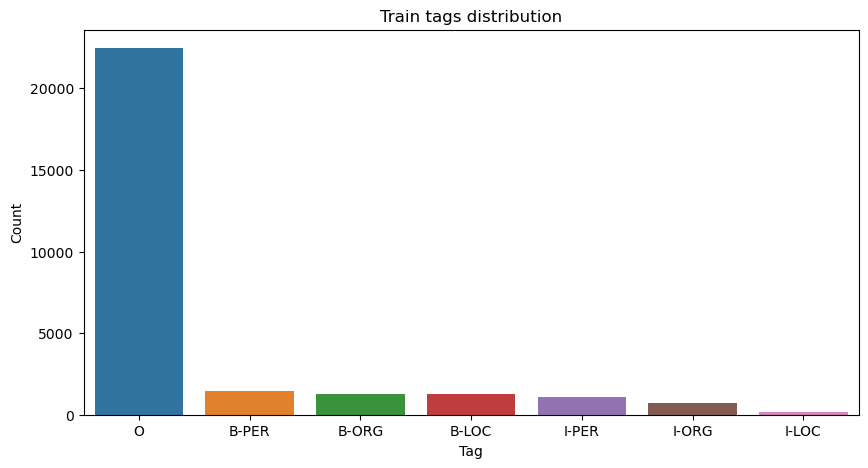

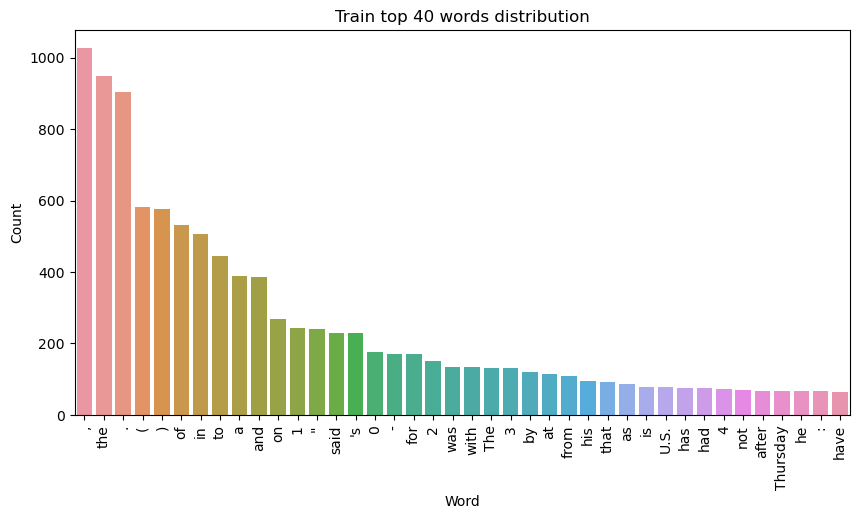

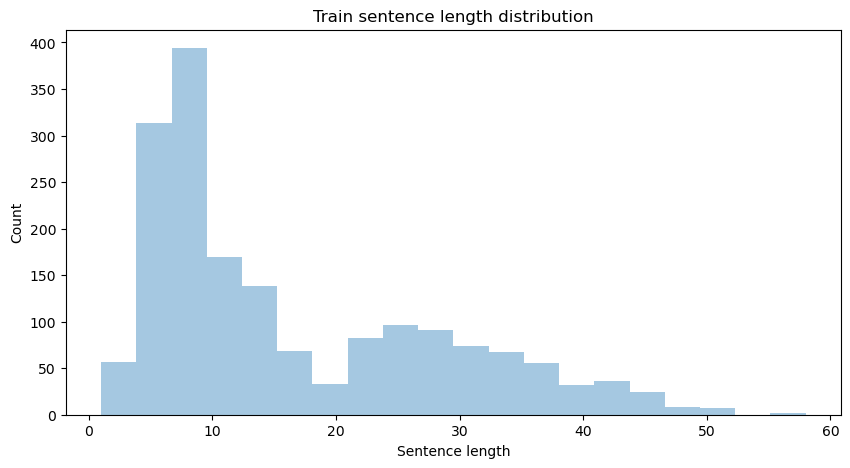

In [8]:
# eda (exploratory data analysis)
train_data = train
dev_data = dev
test_data = test

# train
train_words = [word for sentence in train_data for word in sentence[0]]
train_tags = [tag for sentence in train_data for tag in sentence[1]]
train_tags_count = pd.Series(train_tags).value_counts()

# dev
dev_words = [word for sentence in dev_data for word in sentence[0]]
dev_tags = [tag for sentence in dev_data for tag in sentence[1]]

# test
test_words = [word for sentence in test_data for word in sentence[0]]
test_tags = [tag for sentence in test_data for tag in sentence[1]]

# all
all_words = train_words + dev_words + test_words
all_tags = train_tags + dev_tags + test_tags

# unique
unique_words = set(all_words)
unique_tags = set(all_tags)

print(f'Unique words: {len(unique_words)}')
print(f'Unique tags: {len(unique_tags)}')
print(f'Unique tags: {unique_tags}')
print("train data size: ", len(train_data))
print("dev data size: ", len(dev_data))
print("test data size: ", len(test_data))
print("number of words in train data: ", len(train_words))
print("number of words in dev data: ", len(dev_words))
print("number of words in test data: ", len(test_words))

# plot tags
plt.figure(figsize=(10, 5))
sns.barplot(x=train_tags_count.index, y=train_tags_count.values)
plt.title('Train tags distribution')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.show()

# plot top 40 words
plt.figure(figsize=(10, 5))
sns.barplot(x=pd.Series(train_words).value_counts().index[:40], y=pd.Series(train_words).value_counts().values[:40])
plt.title('Train top 40 words distribution')
plt.xticks(rotation=90)
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

# plot sentence length
plt.figure(figsize=(10, 5))
sns.distplot([len(sentence[0]) for sentence in train_data], kde=False)
plt.title('Train sentence length distribution')
plt.xlabel('Sentence length')
plt.ylabel('Count')
plt.show()


<br><br><br><br><br><br>



## Task 2:

The following Vocab class can be served as a dictionary that maps words and tags into Ids.   
The UNK_TOKEN should be used for words that are not part of the training data.

Note: you may change the Vocab class

In [9]:
# To DO
UNK_TOKEN = "<UNK>"
PAD_TOKEN = "<PAD>"

class Vocab:
    def __init__(self, train: List[Tuple[List[str], List[str]]]):
        # initialize word2id and id2word dictionaries with PAD_TOKEN and UNK_TOKEN
        self.word2id = {PAD_TOKEN: 0, UNK_TOKEN: 1}
        self.id2word = {0: PAD_TOKEN, 1: UNK_TOKEN}
        self.n_words = 2

        # initialize tag2id and id2tag dictionaries
        self.tag2id = {}
        self.id2tag = {}

        # initialize based on train dataset
        for sentence, tags in train:
            self._index_words(sentence)
            self._index_tags(tags)
        

    def _index_tags(self, tags: List[str]) -> List[int]:
        # convert tags to their corresponding ids
        tag_indexes = [self._index_tag(t) for t in tags]
        return tag_indexes

    def _index_words(self, words: List[str]) -> List[int]:
        # convert words to their corresponding ids
        word_indexes = [self._index_word(w) for w in words]
        return word_indexes

    def _index_word(self, w: str) -> int:
        # add new word to word2id and id2word dictionaries if it doesn't exist
        if w not in self.word2id:
            self.word2id[w] = self.n_words
            self.id2word[self.n_words] = w
            self.n_words += 1
        return self.word2id[w]

    def _index_tag(self, t: str) -> int:
        # add new tag to tag2id and id2tag dictionaries if it doesn't exist
        if t not in self.tag2id:
            self.tag2id[t] = len(self.tag2id)
            self.id2tag[len(self.id2tag)] = t
        return self.tag2id[t]
    
    def convert_words_to_ids(self, words: List[str]) -> List[int]:
        # convert list of words to list of corresponding ids
        return [self.word2id.get(w, self.word2id[UNK_TOKEN]) for w in words]
    
    def convert_tags_to_ids(self, tags: List[str]) -> List[int]:
        # convert list of tags to list of corresponding ids
        return [self.tag2id[t] for t in tags]


# Testing - do not change
vcb = Vocab(train)
assert vcb.tag2id.keys() == {"O":0, "B-PER":1, "I-PER": 2, "B-LOC": 3, "I-LOC": 4, "B-ORG": 5, "I-ORG": 6}.keys()
del vcb


In [10]:
# print vocab details
vcb = Vocab(train)
print(f'Vocab size: {vcb.n_words}')
print(f'Tag size: {len(vcb.tag2id)}')
# print(f'Word to id: {vcb.word2id}')
# print(f'Tag to id: {vcb.tag2id}')


Vocab size: 7163
Tag size: 7


Write a function prepare_data that takes one of the [train, dev, test] and the Vocab instance, for converting each pair of (words,tags) to a pair of indexes.  

Each pair should be added to data_sequences, which will be returned back from the function.

Note: Vocabulary is based only on the train set.

In [11]:
def prepare_data(data, _vocab=None):
    data_sequences = []
    # initialize vocab if not provided
    if _vocab is None:
        _vocab = Vocab(data)
    # convert words and tags to ids
    data_sequences = [( _vocab.convert_words_to_ids(sentence), _vocab.convert_tags_to_ids(tags)) for sentence, tags in data]
    
    return data_sequences, _vocab

# sequences - list of tuples (word_indexes, tag_indexes)
train_sequences, vocab = prepare_data(train)
dev_sequences, _ = prepare_data(dev, vocab)
test_sequences, _ = prepare_data(test, vocab)

In [12]:
#print example
print('Example:')
print('Sentence:', train_data[0][0])
print('Tags:', train_data[0][1])
print('Word indexes:', train_sequences[0][0])
print('Tag indexes:', train_sequences[0][1])


Example:
Sentence: ['Portuguesa', '2', 'Parana', '0']
Tags: ['B-ORG', 'O', 'B-ORG', 'O']
Word indexes: [2, 3, 4, 5]
Tag indexes: [0, 1, 0, 1]


Print: how many OOV words are in the dev dataset? 

In [13]:
# print how many OOV words in the dev dataset, each OOV word was replaced with UNK_TOKEN
dev_words = [word for sentence in dev_sequences for word in sentence[0]]
dev_oov = [word for word in dev_words if word == vocab.word2id[UNK_TOKEN]]
dev_num_oov = len(dev_oov)
print('Number of OOV words in the dev dataset:', dev_num_oov)

Number of OOV words in the dev dataset: 638


Print: how many OOV words are in the test dataset? 

In [14]:
# print how many OOV words in the test dataset, each OOV word was replaced with UNK_TOKEN
test_words = [word for sentence in test_sequences for word in sentence[0]]
test_oov = [word for word in test_words if word == vocab.word2id[UNK_TOKEN]]
test_num_oov = len(test_oov)
print('Number of OOV words in the test dataset:', test_num_oov)

Number of OOV words in the test dataset: 1368


In [15]:
# TODO: Delete this cell before submitting, just a sanity check

# print how many OOV words in the train dataset, each OOV word was replaced with UNK_TOKEN
train_words = [word for sentence in train_sequences for word in sentence[0]]
train_oov = [word for word in train_words if word == vocab.word2id[UNK_TOKEN]]
train_num_oov = len(train_oov)
print('Number of OOV words in the train dataset:', train_num_oov)

Number of OOV words in the train dataset: 0


<br><br><br><br><br><br>

## Task 3:

Write NERNet, a PyTorch Module for labeling words with NER tags. 

> `input_size`: the size of the vocabulary  
`embedding_size`: the size of the embeddings  
`hidden_size`: the LSTM hidden size  
`output_size`: the number tags we are predicting for  
`n_layers`: the number of layers we want to use in LSTM  
`directions`: could 1 or 2, indicating unidirectional or bidirectional LSTM, respectively  

<br>  

The input for your forward function should be a single sentence tensor.

*Note: the embeddings in this section are learned embedding. That means that you don't need to use pretrained embedding like the one used in class. You will use them in part 5.*

*Note: You may change the NERNet class.* 

In [16]:
# You may change the NERNet class.
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
from torch import LongTensor

class NERNet(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, output_size, n_layers=1, dropout=0.0, bidirectional=False):
        super(NERNet, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_size, padding_idx=vocab.word2id[PAD_TOKEN])
        self.lstm = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, dropout=dropout , bidirectional=bidirectional)
        self.out = nn.Linear(in_features=hidden_size * (2 if bidirectional else 1), out_features=output_size)
    
    def forward(self, input_sentence):
        # get the embeddings
        embeds = self.embedding(input_sentence)
        # get the lengths of each sequence in the batch
        lengths = (input_sentence != vocab.word2id[PAD_TOKEN]).sum(dim=1)
        # convert lengths cpu tensor to list (needed for pack_padded_sequence)
        lengths = lengths.tolist()
        # pack the padded sequences
        packed_embeds = pack_padded_sequence(embeds, lengths, batch_first=True, enforce_sorted=False)
        # run the LSTM over the packed sequence
        lstm_out_packed, _ = self.lstm(packed_embeds)
        # unpack the padded sequences
        lstm_out, _ = pad_packed_sequence(lstm_out_packed, batch_first=True)
        # get the scores for the most likely tag for each word
        tag_space = self.out(lstm_out)
        # convert scores to log probabilities
        tag_scores = F.log_softmax(tag_space, dim=-1)
        return tag_scores

Create a Dataloader for the training phase

In [17]:
from torch.nn.utils.rnn import pad_sequence

# create a custom collate_fn function that converts sequences to tensors and pads them
def collate_fn_no_padding(batch):
  # get the sequences from the batch and convert to tensors
  words = [torch.tensor(seq[0]) for seq in batch]
  tags = [torch.tensor(seq[1]) for seq in batch]
  # pad the sequences
  words = pad_sequence(words, batch_first=True, padding_value=vocab.word2id[PAD_TOKEN])
  tags = pad_sequence(tags, batch_first=True, padding_value=len(vocab.tag2id))
  return words, tags

# create a DataLoader object for a given dataset with padding
def prepare_data_loader(sequences, batch_size=64):
  dataLoader = DataLoader(sequences, batch_size=batch_size, shuffle=True, collate_fn=collate_fn_no_padding)
  return dataLoader

# create DataLoader objects for the training, validation, and testing sequences
dataLoader_train = prepare_data_loader(train_sequences, batch_size=64)
dataLoader_dev = prepare_data_loader(dev_sequences, batch_size=64)
dataLoader_test = prepare_data_loader(test_sequences, batch_size=64)

<br><br><br><br><br><br>

## Task 4:

Write a training loop, which takes a model (instance of NERNet), number of epochs to train on, and the train&dev datasets.  

The function will return the `loss` and `accuracy` durring training.  
(If you're using a different/additional metrics, return them too)

The loss is always CrossEntropyLoss and the optimizer is always Adam.
Make sure to use `tqdm` while iterating on `n_epochs`.


In [18]:
def train(model, criterion, optimizer, dataloader_train, pad_tag_id):
  # set the model to training mode
  model.train()
  # initialize variables to track loss and accuracy
  train_loss = 0
  train_correct = 0
  train_total = 0
  # iterate over the training data
  for inputs, labels in dataloader_train:
    # convert inputs and labels to the appropriate device
    inputs = inputs.to(DEVICE)
    labels = labels.to(DEVICE)
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass
    outputs = model.forward(inputs)
    # calculate the loss
    loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
    # backward pass
    loss.backward()
    # update the parameters
    optimizer.step()
    # calculate the training loss
    train_loss += loss.item()
    # calculate the training accuracy (ignoring PAD_TOKEN)
    train_correct += ((outputs.argmax(dim=-1) == labels) * (labels != pad_tag_id)).sum().item()
    train_total += (labels != pad_tag_id).sum().item()
    
  # calculate the average training loss and accuracy
  train_loss /= len(dataloader_train)
  train_accuracy = train_correct / train_total
  return train_loss, train_accuracy

In [19]:
def evaluate_acc_and_loss(model, criterion, dataloader_dev, pad_tag_id):
  # set the model to evaluation mode (turns off dropout and batch normalization)
  model.eval()
  # initialize variables to track loss and accuracy
  dev_loss = 0
  dev_correct = 0
  dev_total = 0
  # disable gradient calculation
  with torch.no_grad():
    # iterate over the dev data
    for inputs, labels in dataloader_dev:
      # convert inputs and labels to the appropriate device
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      # forward pass
      outputs = model(inputs)
      # calculate the loss
      loss = criterion(outputs.view(-1, outputs.shape[-1]), labels.view(-1))
      # calculate the dev loss
      dev_loss += loss.item()
      # calculate the dev accuracy (ignoring PAD_TOKEN)
      dev_correct += ((outputs.argmax(dim=-1) == labels) * (labels != pad_tag_id)).sum().item()
      dev_total += (labels != pad_tag_id).sum().item()

  # calculate the average dev loss and accuracy
  dev_loss /= len(dataloader_dev)
  dev_accuracy = dev_correct / dev_total
  return dev_loss, dev_accuracy


In [20]:
def train_loop(model, n_epochs, dataloader_train, dataloader_dev, pad_tag_id):
  # define the loss function and optimizer
  criterion = nn.CrossEntropyLoss(ignore_index=pad_tag_id)
  optimizer = Adam(model.parameters(), lr=0.0001)

  # initialize a dictionary to store the metrics
  metrics = {'loss': {'train': [], 'dev': []}, 'accuracy': {'train': [], 'dev': []}}

  # iterate over the specified number of epochs
  for epoch in tqdm(range(n_epochs)):
    train_loss, train_accuracy = train(model, criterion, optimizer, dataloader_train, pad_tag_id)
    dev_loss, dev_accuracy = evaluate_acc_and_loss(model, criterion, dataloader_dev, pad_tag_id)

    # store the metrics
    metrics['loss']['train'].append(train_loss)
    metrics['accuracy']['train'].append(train_accuracy)
    metrics['loss']['dev'].append(dev_loss)
    metrics['accuracy']['dev'].append(dev_accuracy)

  # return the metrics
  return metrics

In [21]:
# train the model
model_part4 = NERNet(input_size=len(vocab.word2id), embedding_size=300, hidden_size=512, output_size=len(vocab.tag2id), n_layers=2, dropout=0.5, bidirectional=True).to(DEVICE)
metrics_part4 = train_loop(model_part4, n_epochs=20, dataloader_train=dataLoader_train, dataloader_dev=dataLoader_dev, pad_tag_id=len(vocab.tag2id))

100%|██████████| 20/20 [00:19<00:00,  1.01it/s]


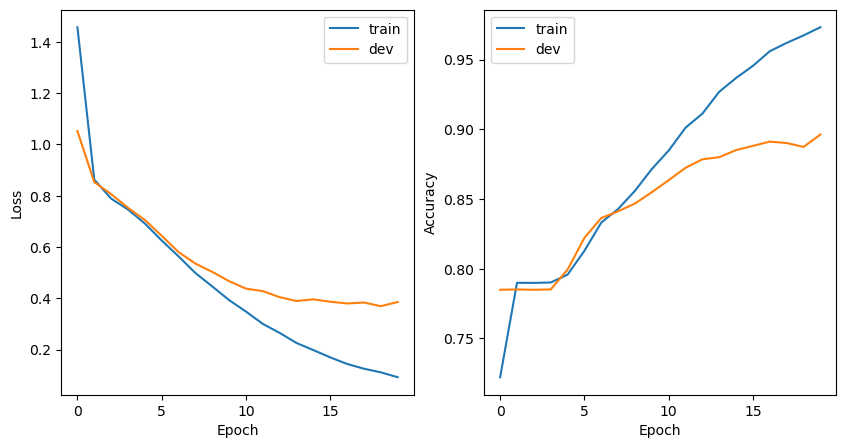

In [22]:
# plot the loss and accuracy curves
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(metrics_part4['loss']['train'], label='train')
plt.plot(metrics_part4['loss']['dev'], label='dev')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(metrics_part4['accuracy']['train'], label='train')
plt.plot(metrics_part4['accuracy']['dev'], label='dev')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

<br><br><br><br><br><br>

## Task 5:
Write an evaluation loop on a trained model, using the dev and test datasets.   
This function will print a `RECALL-PERCISION-F1` scores and plot a `confusion matrix`.  

Do this twice: once for all the labels (7 labels in total), and once for all the labels except O (6 labels in total).   





Metrics:
- `Recall`: true positive rate (TPR), also known as Recall.
- `Percision`: the opposite to false positive rate (FPR), also known as precision.
- `F1 score`: harmonic average
- *For all these metries use **weighted**:
Calculate metrics for each label, and find their average weighted by support ([link](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

To display:
1. Print a `RECALL-PERCISION-F1` scores in a `tabulate` format (similar to assignment#2)
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.


In [23]:
# TODO: DELETE
def get_flattened_actuals_and_predictions_OG(model, dataloader, vocab, pad_token=PAD_TOKEN):
    # set the model to evaluation mode
    model.eval()
    # initialize the actual and predicted tags
    actuals = []
    predictions = []
    with torch.no_grad():
        # loop over the data in the dataloader
        for inputs, labels in dataloader:
            # move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # get the model outputs and predicted tags
            outputs = model.forward(inputs)
            outputs = outputs.argmax(dim=-1)

            # loop over the sequences in the batch
            for i in range(inputs.size(0)):
                # get the sequence and its corresponding outputs and labels
                seq = inputs[i]
                try:
                    pad_start_idx = (seq == vocab.word2id[pad_token]).nonzero(as_tuple=True)[0][0]
                except IndexError:  # if no padding token is found
                    pad_start_idx = len(seq)

                seq_outputs = outputs[i, :pad_start_idx]
                seq_labels = labels[i, :pad_start_idx]

                # convert the predicted and actual tags to their corresponding strings
                predicted_tags = [vocab.id2tag[tag.item()] for tag in seq_outputs]
                actual_tags = [vocab.id2tag[tag.item()] for tag in seq_labels]

                # add the predicted and actual tags to the lists
                actuals.extend(actual_tags)
                predictions.extend(predicted_tags)

    # return the actual and predicted tags
    return actuals, predictions

# define a function to get the actual and predicted tags
def get_flattened_actuals_and_predictions(model, dataloader, vocab, pad_token=PAD_TOKEN):
    # set the model to evaluation mode
    model.eval()
    # initialize the actual and predicted tags
    actuals = []
    predictions = []
    with torch.no_grad():
        # loop over the data in the dataloader
        for inputs, labels in dataloader:
            # move the inputs and labels to the device
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # get the model outputs and predicted tags
            outputs = model.forward(inputs)
            outputs = outputs.argmax(dim=-1)

            # get the mask for the padding tokens
            padding_mask = (inputs != vocab.word2id[pad_token]).float()

            # convert the predicted and actual tags to their corresponding strings
            predicted_tags = [vocab.id2tag[tag.item()] for tag in outputs[padding_mask.bool()]]
            actual_tags = [vocab.id2tag[tag.item()] for tag in labels[padding_mask.bool()]]

            # add the predicted and actual tags to the lists
            actuals.extend(actual_tags)
            predictions.extend(predicted_tags)

    # return the actual and predicted tags
    return actuals, predictions

# define a function to remove 'O' tags from the actual and predicted tags
def remove_O_tags(actuals, predictions):
    # get all positions of 'O' in actuals
    actuals_O_idx = [i for i, tag in enumerate(actuals) if tag == 'O']
    # remove actuals_O_idx from actuals and predictions
    actuals_without_O = [tag for i, tag in enumerate(actuals) if i not in actuals_O_idx]
    predictions_without_O = [tag for i, tag in enumerate(predictions) if i not in actuals_O_idx]
    # return the actual and predicted tags without 'O' tags
    return actuals_without_O, predictions_without_O

In [24]:
# returns percison, recall, f1 score and confusion matrix (with or without 'O' tags)
def evaluate_model_percision_recall_f1_cm(model, dataloader, vocab, pad_token=PAD_TOKEN, without_O=False):
    # get the actual and predicted tags
    actuals, predictions = get_flattened_actuals_and_predictions(model, dataloader, vocab)

    if without_O:
        actuals, predictions = remove_O_tags(actuals, predictions)

    # calculate the precision, recall, and f1 scores (weighted average)
    precision, recall, score = precision_recall_fscore_support(actuals, predictions, labels=list(vocab.tag2id.keys()), average='weighted')[:3]

    # calculate the confusion matrix
    cm = confusion_matrix(actuals, predictions, labels=list(vocab.tag2id.keys()))

    # return the evaluation metrics and confusion matrix
    return precision, recall, score, cm

def plot_confusion_matrix(cm, labels, title):
    # transpose the confusion matrix (predicted as rows, actual as columns)
    cm = cm.T
    # plot the confusion matrix using seaborn heatmap
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    plt.show()

# print the evaluation metrics and confusion matrix for one evaluation (with or without 'O')
def print_evaluation_percision_recall_f1(precision, recall, score, cm, without_O, title, vocab):
    print(title)
    # print the evaluation metrics
    print('Evaluation ' + ('without O tags:' if without_O else 'with O tags:'))
    print(tabulate([['Precision', precision], ['Recall', recall], ['F1 Score', score]], headers=['Metric', 'Score']))
    print('\n')

# evaluate the model and print the evaluation metrics
def evaluate_print_and_plot(model, title, dataloader, vocab, pad_token=PAD_TOKEN):
    # evaluate the model and get the evaluation metrics
    precision, recall, score, cm = evaluate_model_percision_recall_f1_cm(model, dataloader, vocab, pad_token, without_O=False)
    precision_without_O, recall_without_O, score_without_O, cm_without_O = evaluate_model_percision_recall_f1_cm(model, dataloader, vocab, pad_token, without_O=True)
    
    # print the evaluation metrics and confusion matrix (with 'O' tags)
    print_evaluation_percision_recall_f1(precision, recall, score, cm, False, title, vocab)
    # plot the confusion matrix (with 'O' tags)
    plot_confusion_matrix(cm, list(vocab.tag2id.keys()), title + ' (including O tags)')

    # print the evaluation metrics and confusion matrix (without 'O' tags)
    print_evaluation_percision_recall_f1(precision_without_O, recall_without_O, score_without_O, cm_without_O, True, title, vocab)
    # plot the confusion matrix (without 'O' tags)
    plot_confusion_matrix(cm_without_O, list(vocab.tag2id.keys()), title + ' (excluding O tags)')


Train
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.980429
Recall     0.980731
F1 Score   0.980323




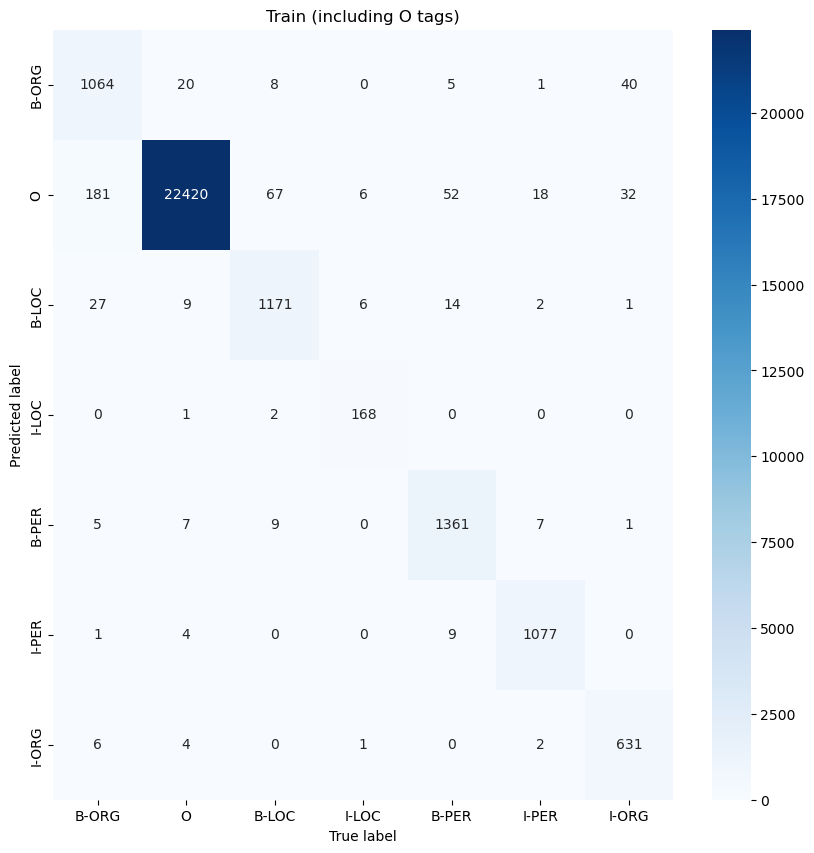

Train
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.973449
Recall     0.915816
F1 Score   0.943276




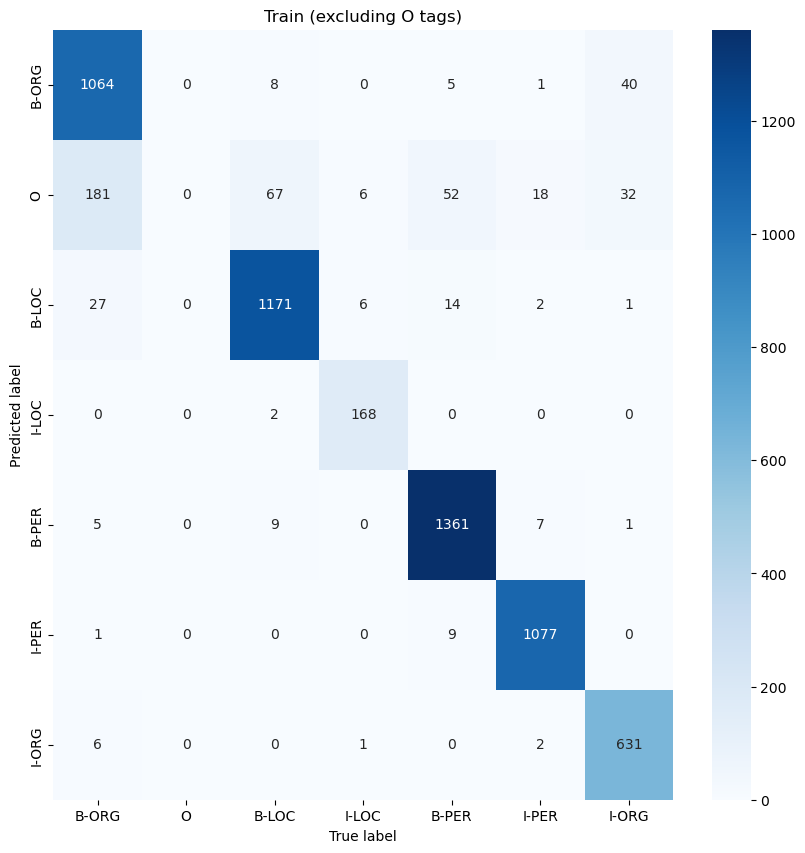

Dev
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.889935
Recall     0.896272
F1 Score   0.890371




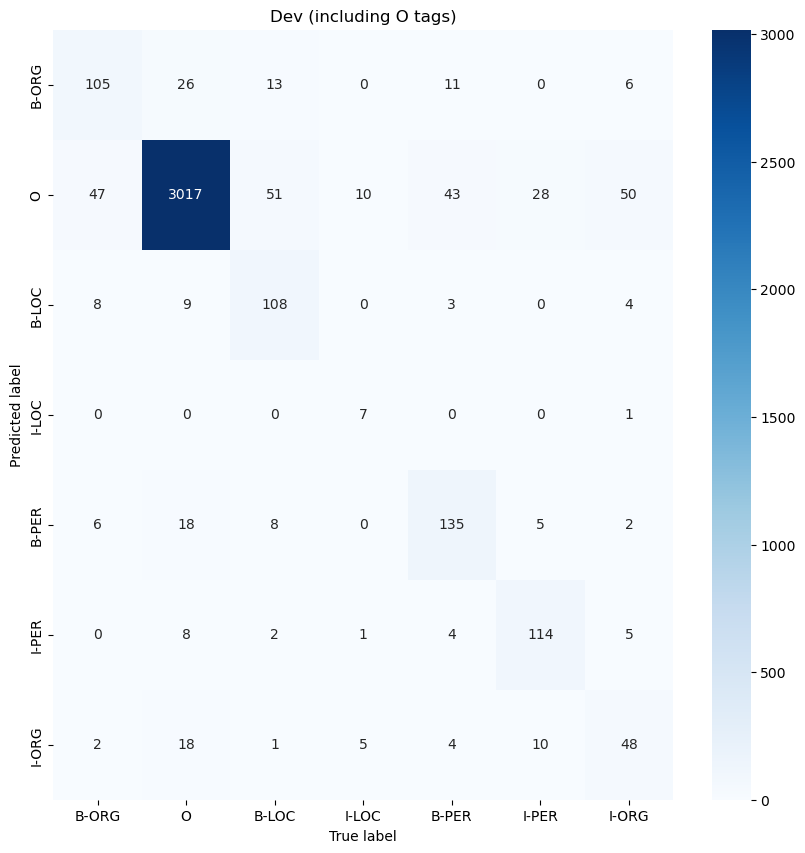

Dev
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.833698
Recall     0.61039
F1 Score   0.70135




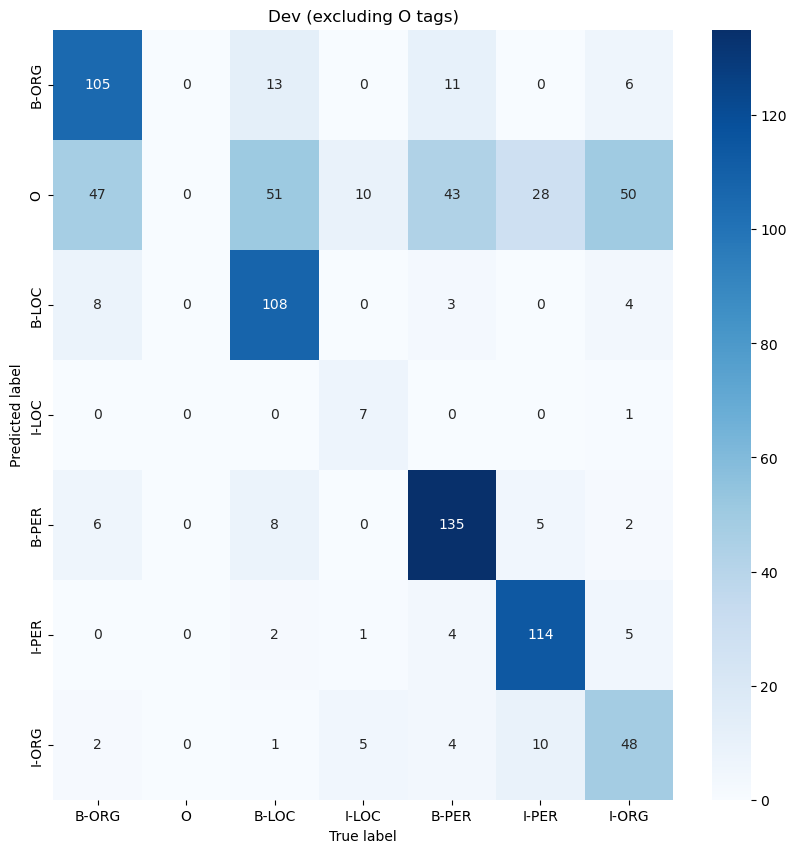

Test
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.898548
Recall     0.900158
F1 Score   0.897131




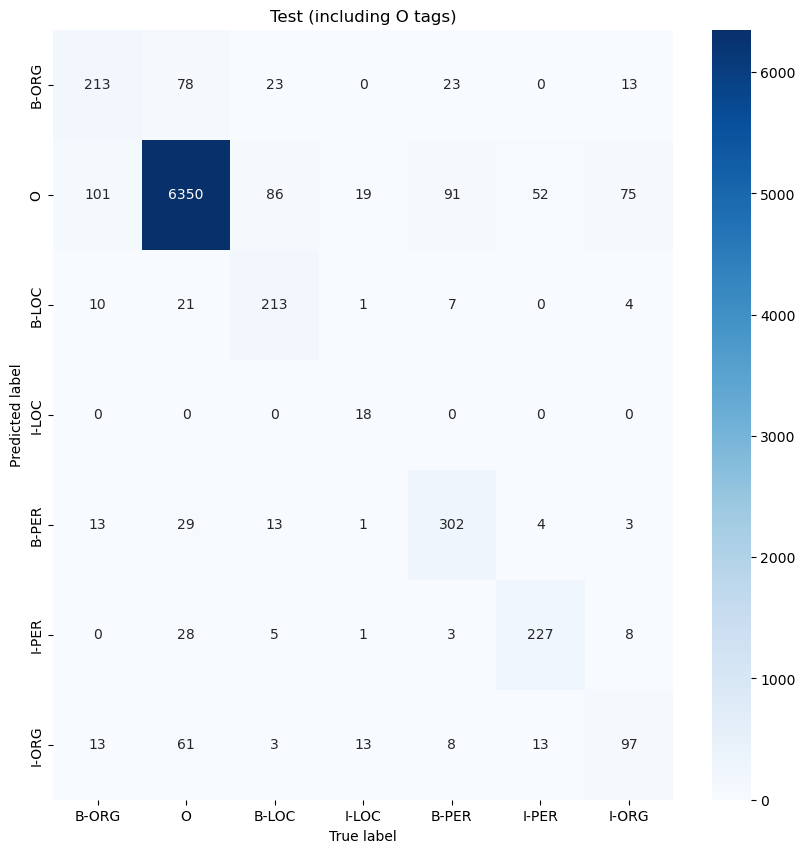

Test
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.856446
Recall     0.638425
F1 Score   0.728219




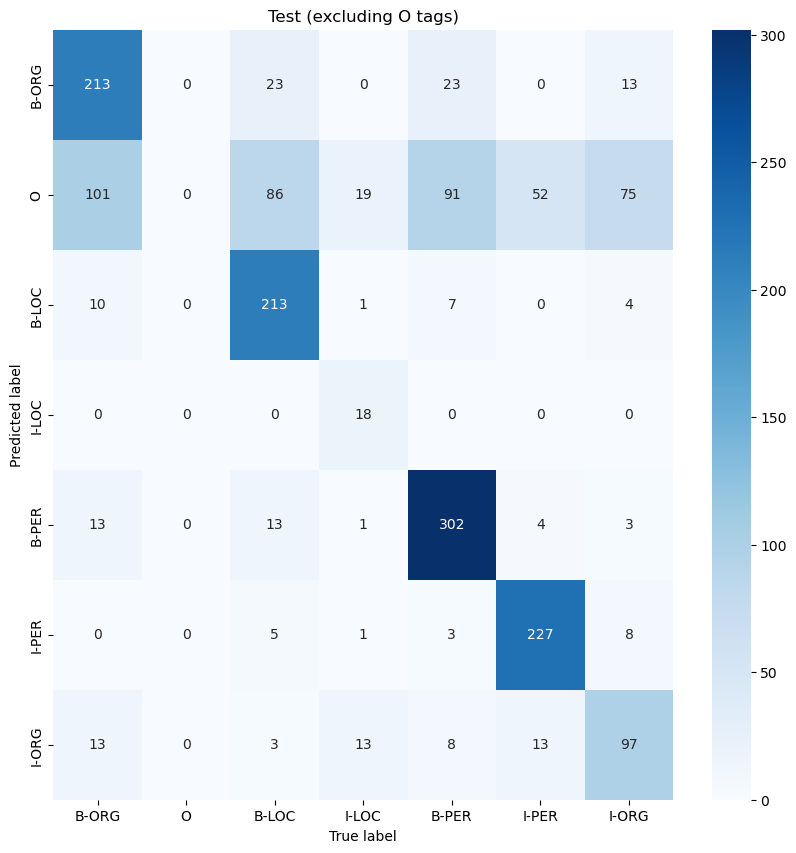

In [25]:
evaluate_print_and_plot(model_part4, 'Train', dataLoader_train, vocab, pad_token=PAD_TOKEN)

evaluate_print_and_plot(model_part4, 'Dev', dataLoader_dev, vocab, pad_token=PAD_TOKEN)

evaluate_print_and_plot(model_part4, 'Test', dataLoader_test, vocab, pad_token=PAD_TOKEN)
    

<br><br><br><br><br><br>

## Task 6:

Reset all seeds to 42.

In [26]:
SEED = 42

# TO DO
# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)

Train and evaluate a few models, all with `embedding_size=300`, and with the following hyper parameters (you may use that as captions for the models as well):

- Model 1: (hidden_size: 500, n_layers: 1, directions: 1)
- Model 2: (hidden_size: 500, n_layers: 2, directions: 1)
- Model 3: (hidden_size: 500, n_layers: 3, directions: 1)
- Model 4: (hidden_size: 500, n_layers: 1, directions: 2)
- Model 5: (hidden_size: 500, n_layers: 2, directions: 2)
- Model 6: (hidden_size: 500, n_layers: 3, directions: 2)
- Model 7: (hidden_size: 800, n_layers: 1, directions: 2)
- Model 8: (hidden_size: 800, n_layers: 2, directions: 2)
- Model 9: (hidden_size: 800, n_layers: 3, directions: 2)




In [27]:
columns = ['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O']
models = {
    'Model1': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 1},
    'Model2': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 1},
    'Model3': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 1},
    'Model4': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 1, 'directions': 2},
    'Model5': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 2, 'directions': 2},
    'Model6': {'embedding_size':300, 'hidden_size': 500, 'n_layers': 3, 'directions': 2},
    'Model7': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 1, 'directions': 2},
    'Model8': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 2, 'directions': 2},
    'Model9': {'embedding_size':300, 'hidden_size': 800, 'n_layers': 3, 'directions': 2},
}

# train and evaluate the models, returning the results in a dataframe
def train_and_evaluate_models(models, vocab, dataLoader_train, dataLoader_dev, dataLoader_test, pad_token):   
    # Create an empty dictionary to store the results for each model
    results_dev = {}
    results_test = {}

    # Loop through each model in the dictionary
    for model_name, model_params in models.items():
        print(f'Training {model_name}')

        # Create the model
        model = NERNet(input_size=len(vocab.word2id), embedding_size=model_params['embedding_size'], hidden_size=model_params['hidden_size'], output_size=len(vocab.tag2id), n_layers=model_params['n_layers'], dropout=0.5 ,bidirectional=model_params['directions'] == 2)
        model.to(DEVICE)

        # Train the model
        metrics = train_loop(model, n_epochs=20, dataloader_train=dataLoader_train, dataloader_dev=dataLoader_dev, pad_tag_id=len(vocab.tag2id))

        # Evaluate the model (dev set)
        precision_dev, recall_dev, f1_score_dev, cm_dev = evaluate_model_percision_recall_f1_cm(model, dataLoader_dev, vocab, pad_token=pad_token, without_O=False)
        precision_without_O_dev, recall_without_O_dev, f1_score_without_O_dev, cm_without_O_dev = evaluate_model_percision_recall_f1_cm(model, dataLoader_dev, vocab, pad_token=pad_token, without_O=True)

        # Evaluate the model (test set)
        precision_test, recall_test, f1_score_test, cm_test = evaluate_model_percision_recall_f1_cm(model, dataLoader_test, vocab, pad_token=pad_token, without_O=False)
        precision_without_O_test, recall_without_O_test, f1_score_without_O_test, cm_without_O_test = evaluate_model_percision_recall_f1_cm(model, dataLoader_test, vocab, pad_token=pad_token, without_O=True)

        # Store the results for this model in the dictionary
        results_dev[model_name] = {
            'N_MODEL': model_name,
            'HIDDEN_SIZE': model_params['hidden_size'],
            'N_LAYERS': model_params['n_layers'],
            'DIRECTIONS': model_params['directions'],
            'RECALL': recall_dev,
            'PERCISION': precision_dev,
            'F1': f1_score_dev,
            'RECALL_WO_O': recall_without_O_dev,
            'PERCISION_WO_O': precision_without_O_dev,
            'F1_WO_O': f1_score_without_O_dev
        }

        # Store the results for this model in the dictionary
        results_test[model_name] = {
            'N_MODEL': model_name,
            'HIDDEN_SIZE': model_params['hidden_size'],
            'N_LAYERS': model_params['n_layers'],
            'DIRECTIONS': model_params['directions'],
            'RECALL': recall_test,
            'PERCISION': precision_test,
            'F1': f1_score_test,
            'RECALL_WO_O': recall_without_O_test,
            'PERCISION_WO_O': precision_without_O_test,
            'F1_WO_O': f1_score_without_O_test

        }

    # Convert the results dictionary to a pandas DataFrame
    results_df_dev = pd.DataFrame.from_dict(results_dev, orient='index')
    results_df_test = pd.DataFrame.from_dict(results_test, orient='index')

    # Return the results DataFrame
    return results_df_dev, results_df_test


In [28]:
results_df_dev, results_df_test = train_and_evaluate_models(models, vocab, dataLoader_train, dataLoader_dev, dataLoader_test, pad_token=PAD_TOKEN)

Training Model1


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:08<00:00,  2.24it/s]


Training Model2


100%|██████████| 20/20 [00:11<00:00,  1.76it/s]


Training Model3


100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Training Model4


100%|██████████| 20/20 [00:12<00:00,  1.62it/s]


Training Model5


100%|██████████| 20/20 [00:19<00:00,  1.03it/s]


Training Model6


100%|██████████| 20/20 [00:26<00:00,  1.33s/it]


Training Model7


100%|██████████| 20/20 [00:17<00:00,  1.13it/s]


Training Model8


100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


Training Model9


100%|██████████| 20/20 [00:45<00:00,  2.27s/it]


**Save CSV**  
In addition, for each model use the `test` dataset and check the model metrics. 

> Metrics:
1. `RECALL`, `PERCISION`,`F1` - for all tags
2. `RECALL_WO_O`,`PERCISION_WO_O`,`F1_WO_O` - for all tags **without** the O tag.
3. *For all these metries use **weighted** ([link](https://https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support:~:text=imbalance%20into%20account.-,%27weighted%27%3A,-Calculate%20metrics%20for))*

> - Save the results in a CSV
`{student_id_1}_{student_id_n}_part6.csv`    
For example: `300123123_200456789_part_6.csv`

> - Print the results as follows:  (results here are random)

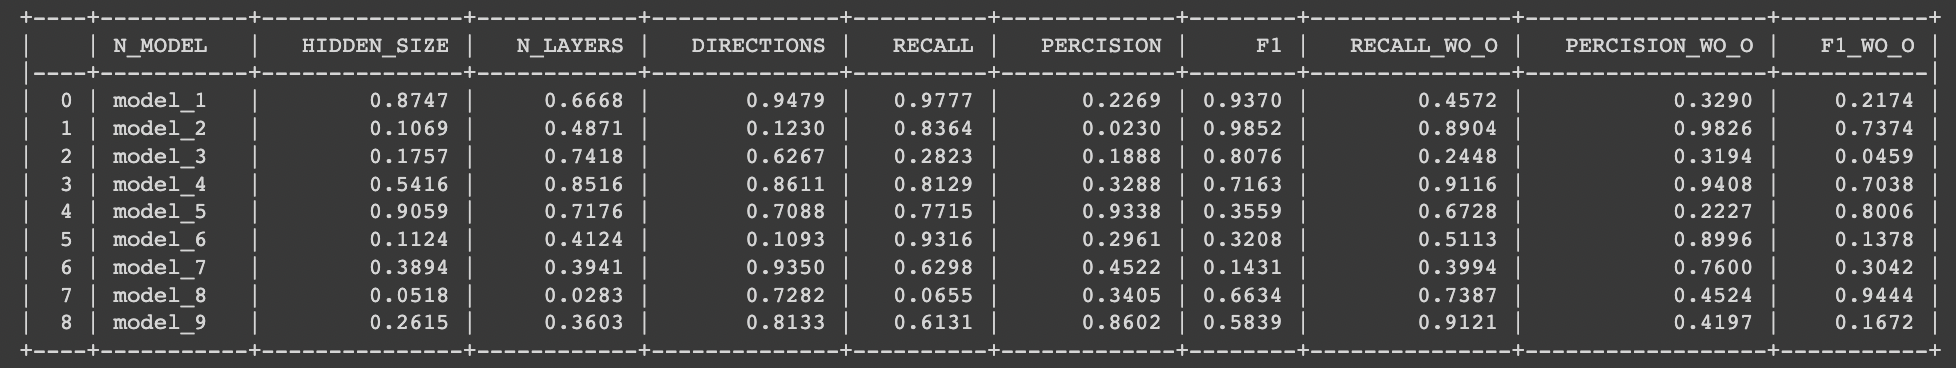

In [29]:
# print the results for the dev set in a table
print("Dev set")
print(tabulate(tabular_data=results_df_dev.values, headers=results_df_dev.columns.tolist(), tablefmt='github', showindex=False), end='\n\n')

# print the results for the test set in a table
print("Test set")
print(tabulate(tabular_data=results_df_test.values, headers=results_df_test.columns.tolist(), tablefmt='github', showindex=False))

Dev set
| N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|-----------|---------------|------------|--------------|----------|-------------|----------|---------------|------------------|-----------|
| Model1    |           500 |          1 |            1 | 0.847578 |    0.834882 | 0.817353 |      0.345927 |         0.832576 |  0.462105 |
| Model2    |           500 |          2 |            1 | 0.843267 |    0.822356 | 0.811573 |      0.323495 |         0.788639 |  0.443097 |
| Model3    |           500 |          3 |            1 | 0.836926 |    0.805815 | 0.815703 |      0.393152 |         0.672364 |  0.476856 |
| Model4    |           500 |          1 |            2 | 0.871671 |    0.857119 | 0.851484 |      0.46281  |         0.814556 |  0.558157 |
| Model5    |           500 |          2 |            2 | 0.896018 |    0.89354  | 0.8935   |      0.655254 |         0.859037 |  0.740827 |
| Mod

In [30]:
# TO DO
# Save the results for the test set to a CSV file
results_df_test.to_csv('results.csv', index=False)

In [31]:
# Example:
# results_acc = np.random.rand(9, 10)
# df = pd.DataFrame(results_acc,columns=['N_MODEL','HIDDEN_SIZE','N_LAYERS','DIRECTIONS','RECALL','PERCISION','F1','RECALL_WO_O','PERCISION_WO_O','F1_WO_O'])
# df.N_MODEL = [f'model_{n}' for n in range(1,10)]
# print(tabulate(df, headers='keys', tablefmt='psql',floatfmt=".4f"))

<br><br><br><br><br>

## Task 7: 

Reset all seeds to 42.

In [32]:
SEED = 42

# TO DO
# Set the random seed for Python to SEED
random.seed(SEED)

# Set the random seed for numpy to SEED
np.random.seed(SEED)

# Set the random seed for torch to SEED
torch.manual_seed(SEED)


In preparation for this task you should read [this](https://discuss.pytorch.org/t/can-we-use-pre-trained-word-embeddings-for-weight-initialization-in-nn-embedding/1222) dicussion.

*TIP: make sure that vectors are aligned with the IDs in your Vocab, in other words, make sure that for example the word with ID 0 is the first vector in the GloVe matrix of vectors that you initialize nn.Embedding with.*

---


Download the GloVe embeddings from https://nlp.stanford.edu/projects/glove/ (use the 300-dim vectors from glove.6B.zip). 


In [33]:
# TO DO
GloVe_path = 'glove.6B/glove.6B.300d.txt'

# load the GloVe embeddings and return them in a dictionary
def load_glove_embeddings(path):
    """Load the GloVe embeddings"""
    # Create an empty dictionary to store the embeddings
    embeddings = {}

    # Open the file
    with open(path, 'r') as f:
        # Loop through each line
        for line in f:
            # Split the line on spaces
            values = line.split()

            # Get the word
            word = values[0]

            # Get the vector
            vector = np.asarray(values[1:], dtype='float32')

            # Store the embedding in the dictionary
            embeddings[word] = vector

    # Return the embeddings dictionary
    return embeddings

# Load the GloVe embeddings
glove_embeddings_dict = load_glove_embeddings(GloVe_path)


Then intialize the `nn.Embedding` module in your `NERNet` with these embeddings, so that you can start your training with pre-trained vectors. 

In [34]:
# Create a new embedding layer using the pre-trained GloVe embeddings
embedding_layer = nn.Embedding(len(vocab.word2id), 300, padding_idx=vocab.word2id[PAD_TOKEN])

# Create a new numpy array with the same shape as the pre-trained GloVe embeddings matrix
weights_matrix = np.zeros((len(vocab.word2id), 300))

# # Set the rows corresponding to the pre-trained embeddings to zero
# for word, index in glove_embeddings_dict.items():
#     if word in vocab.word2id:
#         weights_matrix[vocab.word2id[word]] = np.zeros((300, ))

# Loop through each word in your vocabulary and copy the corresponding embedding from the pre-trained GloVe embeddings matrix
for word, index in vocab.word2id.items():
    if word in glove_embeddings_dict:
        weights_matrix[index] = glove_embeddings_dict[word]
    elif word.lower() in glove_embeddings_dict:
        weights_matrix[index] = glove_embeddings_dict[word.lower()]
    else:
        weights_matrix[index] = np.random.normal(scale=0.6, size=(300, ))

# Copy the new numpy array to the weight attribute of the embedding layer
embedding_layer.weight.data.copy_(torch.from_numpy(weights_matrix))

tensor([[ 2.9803e-01, -8.2959e-02,  3.8861e-01,  ...,  1.8438e-01,
          4.8772e-01,  3.7778e-01],
        [ 4.2919e-01, -2.9690e-01,  1.5011e-01,  ...,  2.8975e-01,
          3.2618e-01, -5.9053e-02],
        [-1.8608e-01,  4.8735e-01, -1.3627e-01,  ...,  6.4405e-02,
          1.5659e-01, -2.3046e-02],
        ...,
        [-7.0296e-01,  5.9309e-01, -1.8979e-01,  ...,  1.3993e-01,
         -1.2569e+00, -1.4225e+00],
        [-3.7157e-01,  1.3890e-03, -1.5517e-01,  ..., -3.0206e-01,
          4.7600e-01,  2.9007e-01],
        [ 7.5248e-03, -6.3986e-02,  1.4648e-01,  ...,  6.5669e-01,
          3.1846e-02, -9.7813e-02]])

Repeat `Task 6`

In [35]:
# TO DO

# Train the models and save in models_dict
models_dict_glove = {}
for model_name, model_params in models.items():
    # Create the model
    model = NERNet(input_size=len(vocab.word2id), embedding_size=model_params['embedding_size'], hidden_size=model_params['hidden_size'], output_size=len(vocab.tag2id), n_layers=model_params['n_layers'], dropout=0.5, bidirectional=model_params['directions'] == 2)
    # Load the embeddings into the model
    model.embedding = embedding_layer
    # dont train the embedding layer (freeze the weights)
    model.embedding.weight.requires_grad = False
    # Move the model to the device
    model.to(DEVICE)

    # Train the model
    metrics = train_loop(model, n_epochs=20, dataloader_train=dataLoader_train, dataloader_dev=dataLoader_dev, pad_tag_id=len(vocab.tag2id))

    # Save the model in the dictionary
    models_dict_glove[model_name] = model
    print(f"Finished training model {model_name}")


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:08<00:00,  2.38it/s]


Finished training model Model1


100%|██████████| 20/20 [00:10<00:00,  1.86it/s]


Finished training model Model2


100%|██████████| 20/20 [00:13<00:00,  1.50it/s]


Finished training model Model3


100%|██████████| 20/20 [00:11<00:00,  1.75it/s]


Finished training model Model4


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]


Finished training model Model5


100%|██████████| 20/20 [00:25<00:00,  1.29s/it]


Finished training model Model6


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Finished training model Model7


100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


Finished training model Model8


100%|██████████| 20/20 [00:44<00:00,  2.24s/it]

Finished training model Model9


In [36]:
results_dev_glove = {}
results_test_glove = {}
cm_dev_glove_dict = {}
cm_dev_glove_dict_without_O = {}
cm_test_glove_dict = {}
cm_test_glove_dict_without_O = {}


for model_name, model in models_dict_glove.items():

    # evaluate the models and save the results in a DataFrame
    precision_dev_glove, recall_dev_glove, f1_score_dev_glove, cm_dev_glove = evaluate_model_percision_recall_f1_cm(model, dataLoader_dev, vocab, pad_token=PAD_TOKEN, without_O=False)
    precision_without_O_dev_glove, recall_without_O_dev_glove, f1_score_without_O_dev_glove, cm_without_O_dev_glove = evaluate_model_percision_recall_f1_cm(model, dataLoader_dev, vocab, pad_token=PAD_TOKEN, without_O=True)

    precision_test_glove, recall_test_glove, f1_score_test_glove, cm_test_glove = evaluate_model_percision_recall_f1_cm(model, dataLoader_test, vocab, pad_token=PAD_TOKEN, without_O=False)
    precision_without_O_test_glove, recall_without_O_test_glove, f1_score_without_O_test_glove, cm_without_O_test_glove = evaluate_model_percision_recall_f1_cm(model, dataLoader_test, vocab, pad_token=PAD_TOKEN, without_O=True)

    # store the results in a dictionary
    results_dev_glove[model_name] = {
        'N_MODEL': model_name,
        'HIDDEN_SIZE': model_params['hidden_size'],
        'N_LAYERS': model_params['n_layers'],
        'DIRECTIONS': model_params['directions'],
        'RECALL': recall_dev_glove,
        'PERCISION': precision_dev_glove,
        'F1': f1_score_dev_glove,
        'RECALL_WO_O': recall_without_O_dev_glove,
        'PERCISION_WO_O': precision_without_O_dev_glove,
        'F1_WO_O': f1_score_without_O_dev_glove

    }

    results_test_glove[model_name] = {
        'N_MODEL': model_name,
        'HIDDEN_SIZE': model_params['hidden_size'],
        'N_LAYERS': model_params['n_layers'],
        'DIRECTIONS': model_params['directions'],
        'RECALL': recall_test_glove,
        'PERCISION': precision_test_glove,
        'F1': f1_score_test_glove,
        'RECALL_WO_O': recall_without_O_test_glove,
        'PERCISION_WO_O': precision_without_O_test_glove,
        'F1_WO_O': f1_score_without_O_test_glove

    }

    cm_dev_glove_dict[model_name] = cm_dev_glove
    cm_dev_glove_dict_without_O[model_name] = cm_without_O_dev_glove
    cm_test_glove_dict[model_name] = cm_test_glove
    cm_test_glove_dict_without_O[model_name] = cm_without_O_test_glove
    



# create a DataFrame from the results
results_df_dev_glove = pd.DataFrame.from_dict(results_dev_glove, orient='index')
results_df_test_glove = pd.DataFrame.from_dict(results_test_glove, orient='index')

Same as `Task 6`, please display:

1. Print a `classification_report` in a tabulate format.
2. Display a `confusion matrix` plot: where the predicted labels are the rows, and the true labels are the columns.

Make sure to use the title for the plot, axis names, and the names of the tags on the X-axis.

Dev Evaluation for model Model1 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.869974
Recall     0.840223
F1 Score   0.845663




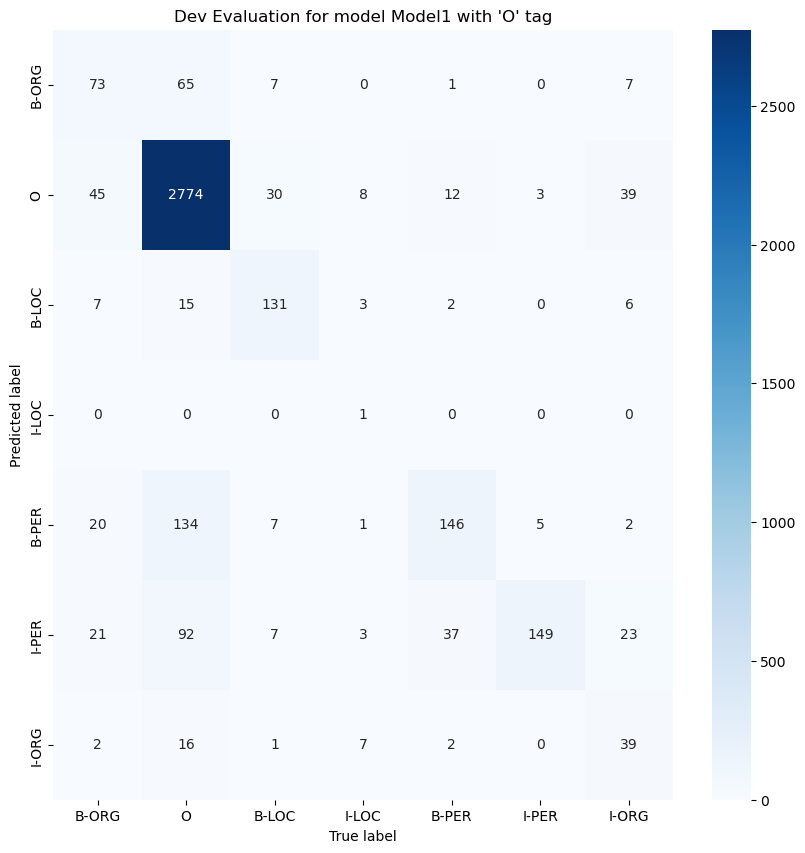

Dev Evaluation for model Model1 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.791923
Recall     0.636364
F1 Score   0.669958




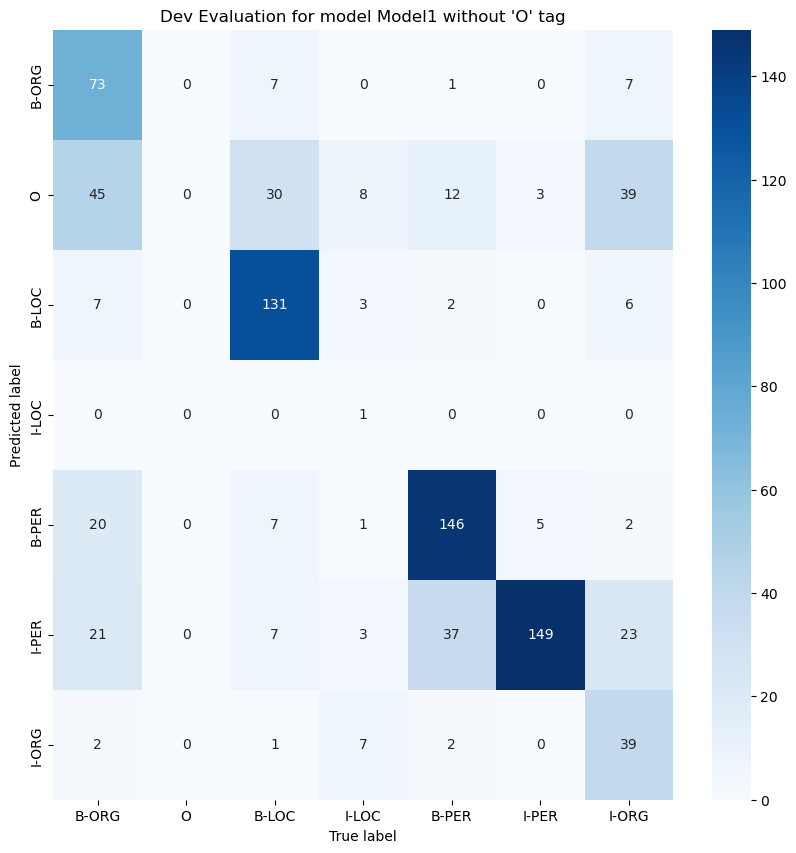

Test Evaluation for model Model1 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.855546
Recall     0.82106
F1 Score   0.831072




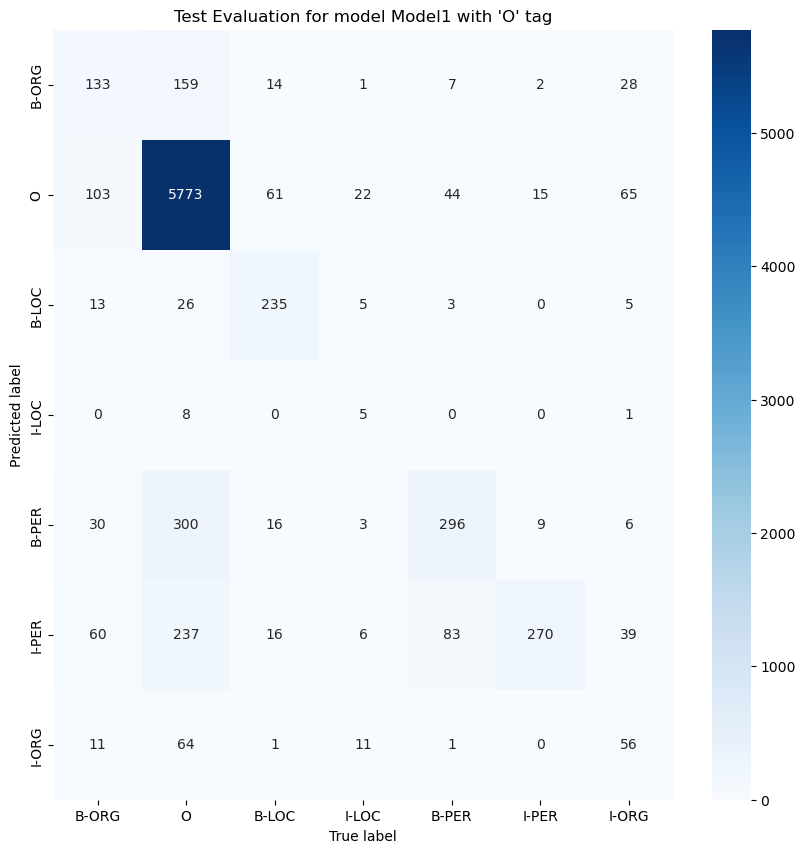

Test Evaluation for model Model1 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.757799
Recall     0.593675
F1 Score   0.633101




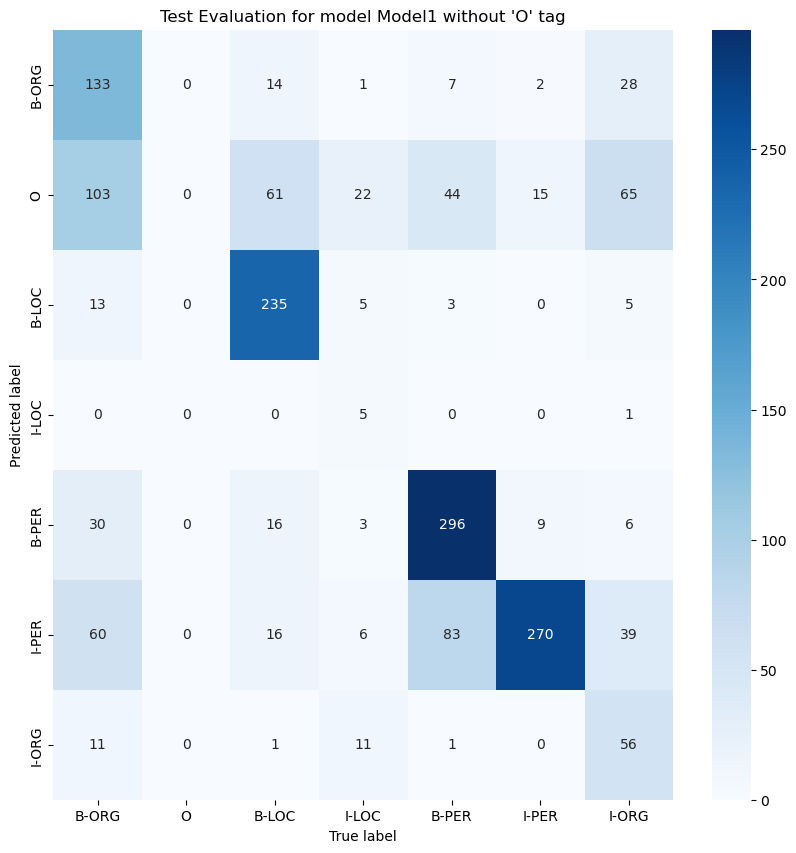

Dev Evaluation for model Model2 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.871794
Recall     0.871164
F1 Score   0.865975




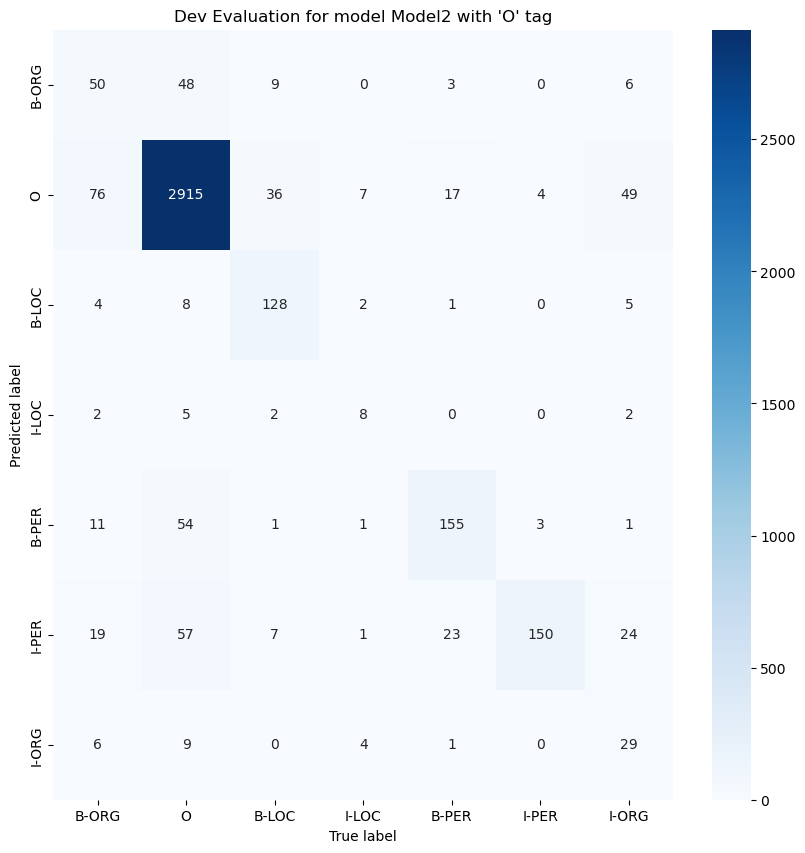

Dev Evaluation for model Model2 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.795104
Recall     0.613932
F1 Score   0.660672




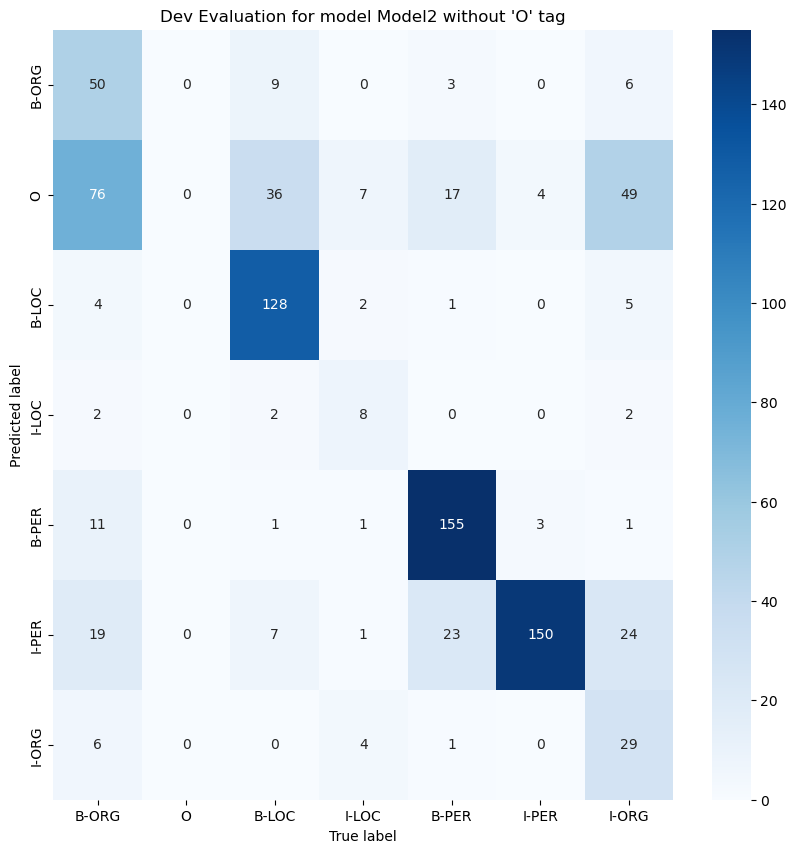

Test Evaluation for model Model2 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.863121
Recall     0.855635
F1 Score   0.854825




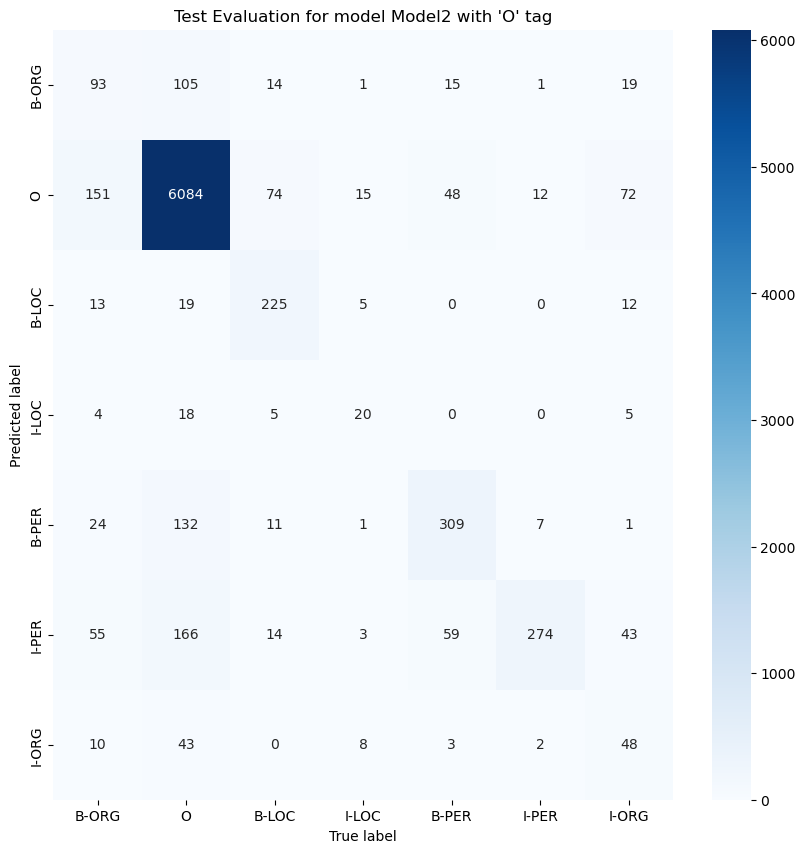

Test Evaluation for model Model2 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.750356
Recall     0.578162
F1 Score   0.623031




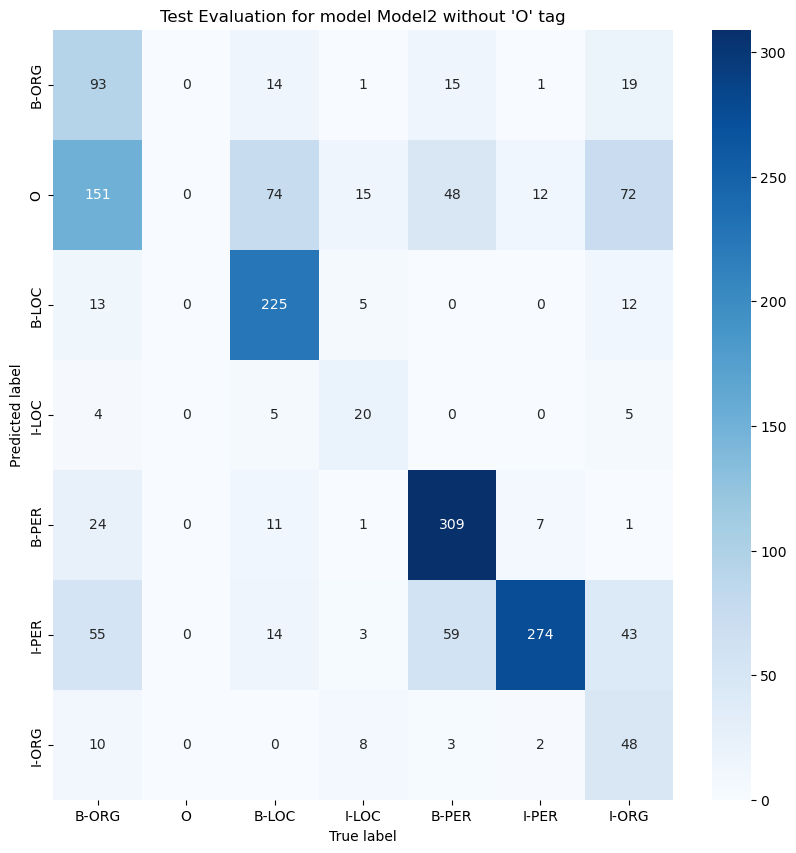

Dev Evaluation for model Model3 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.824298
Recall     0.836926
F1 Score   0.824362




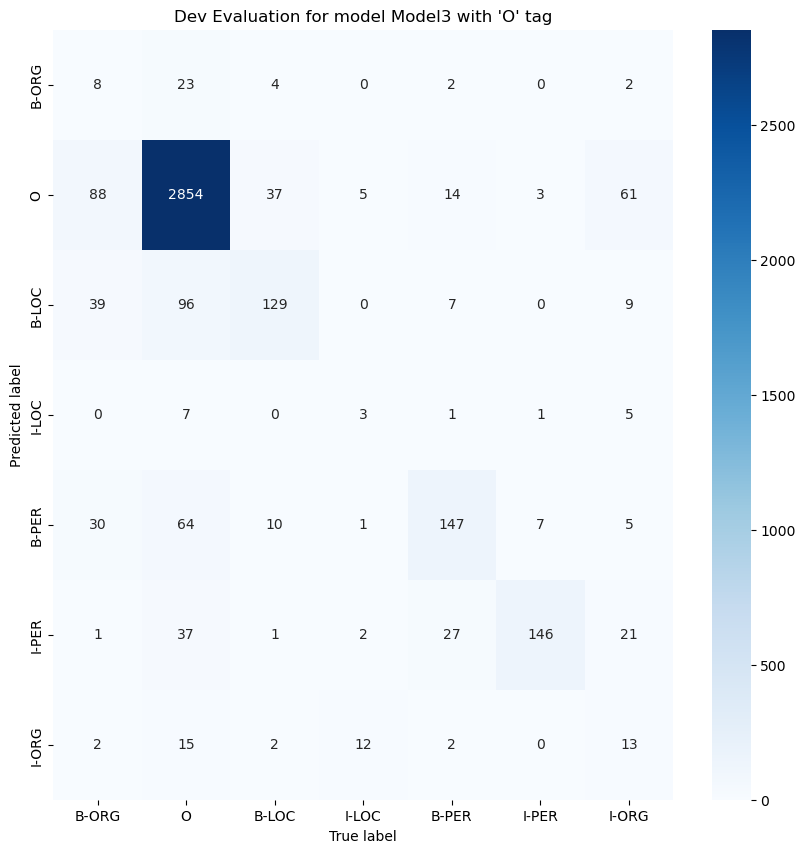

Dev Evaluation for model Model3 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.62646
Recall     0.526564
F1 Score   0.524314




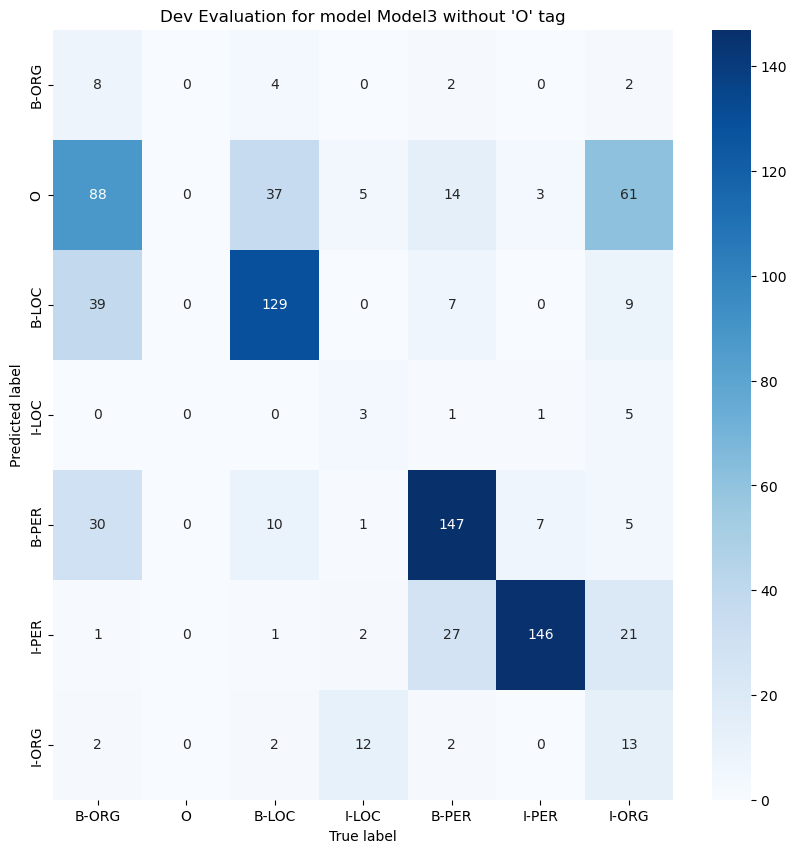

Test Evaluation for model Model3 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.825379
Recall     0.825064
F1 Score   0.819742




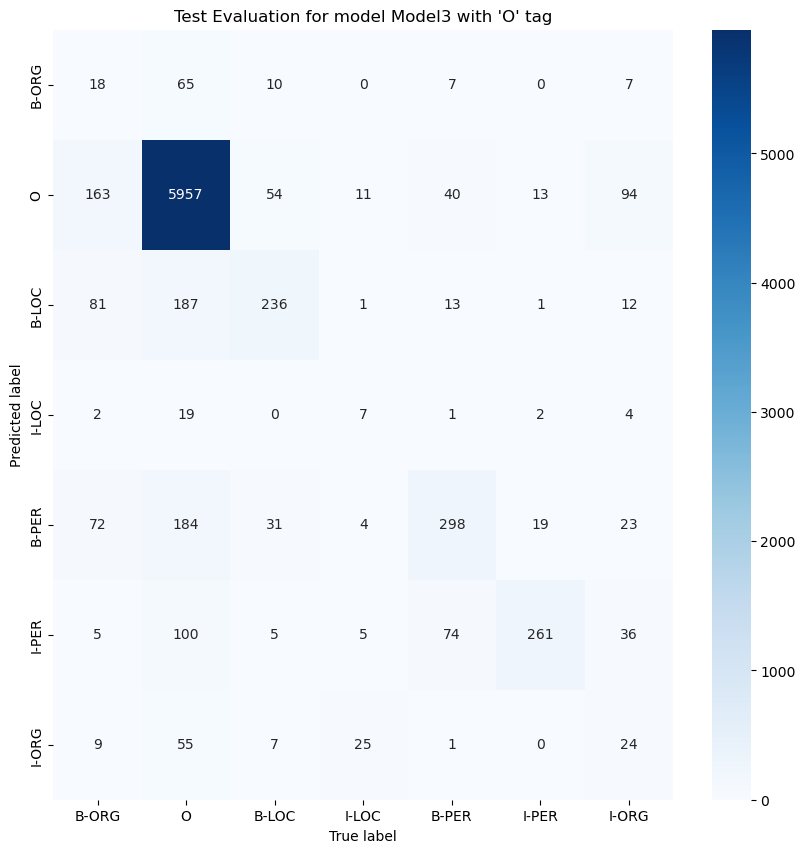

Test Evaluation for model Model3 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.579181
Recall     0.50358
F1 Score   0.498093




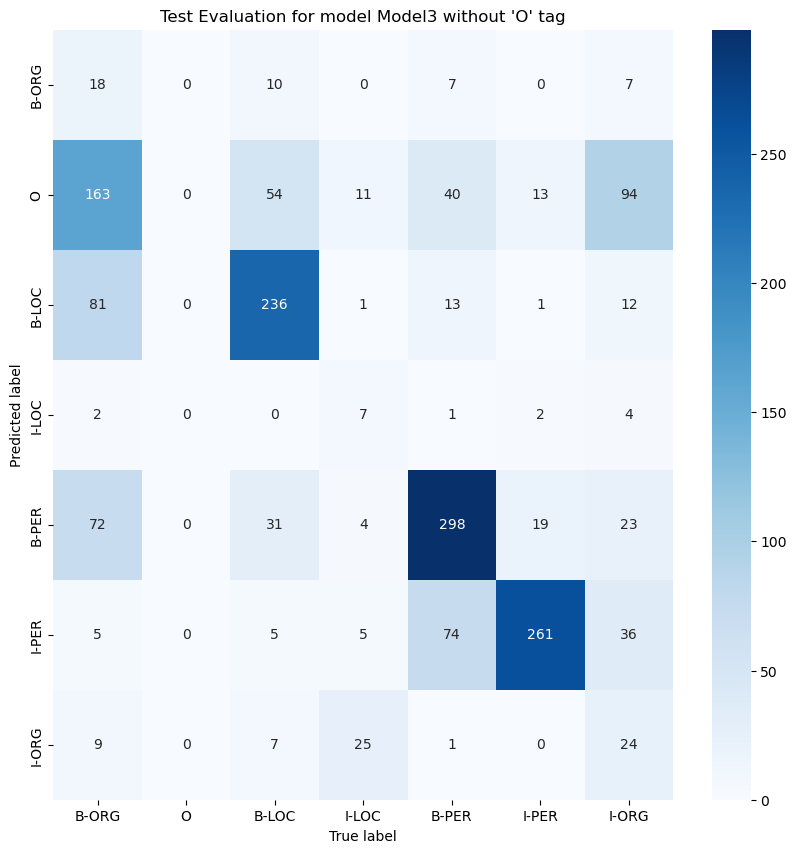

Dev Evaluation for model Model4 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.889563
Recall     0.87649
F1 Score   0.874378




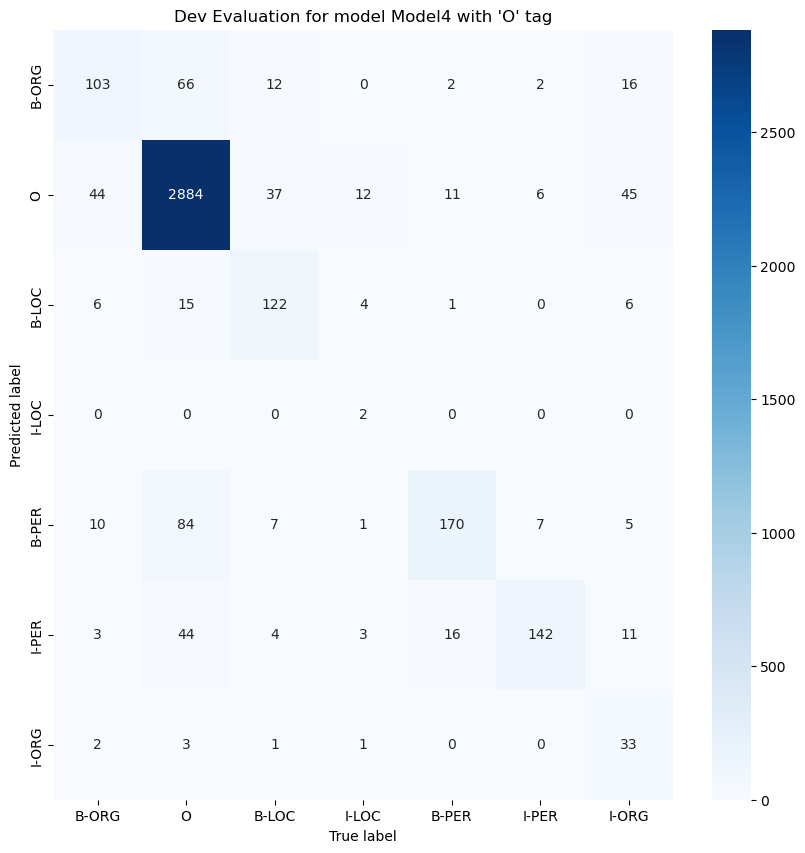

Dev Evaluation for model Model4 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.838021
Recall     0.675325
F1 Score   0.719375




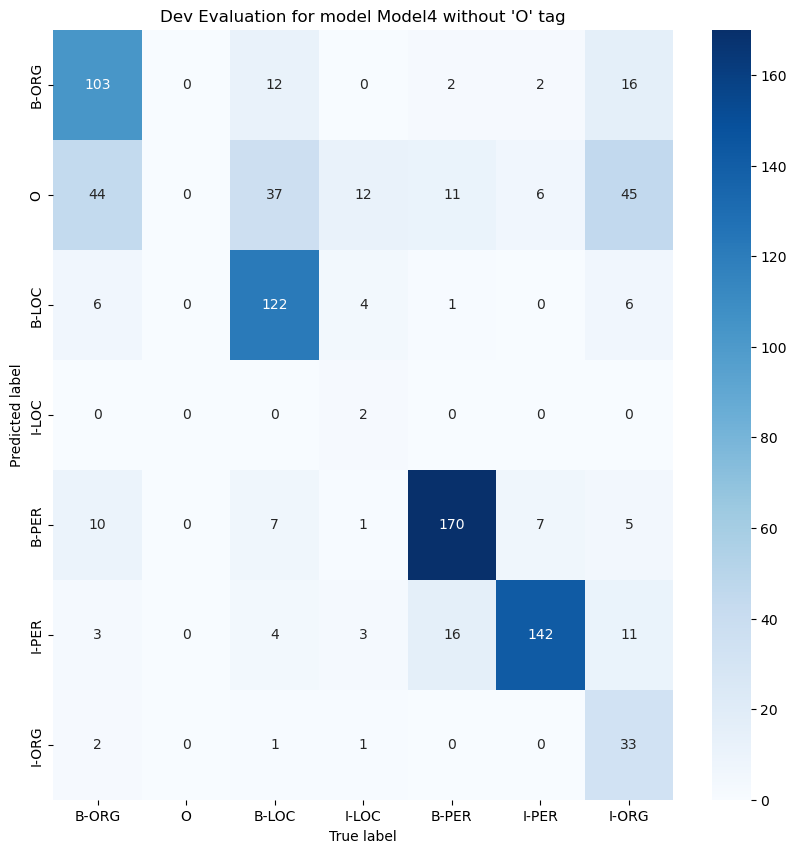

Test Evaluation for model Model4 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.881216
Recall     0.865704
F1 Score   0.867821




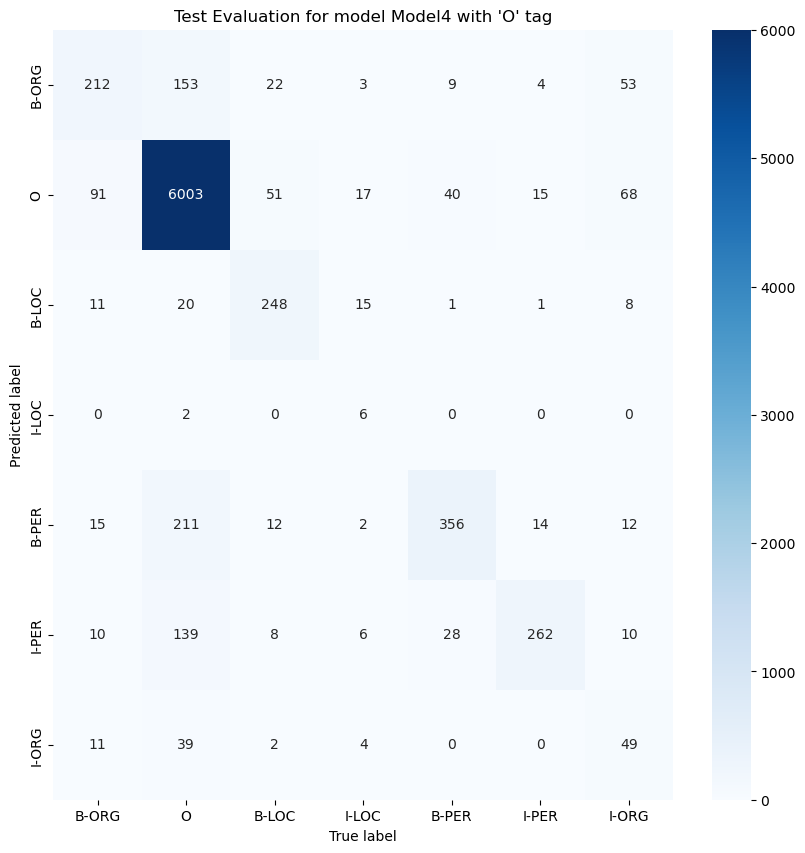

Test Evaluation for model Model4 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.812154
Recall     0.676014
F1 Score   0.715344




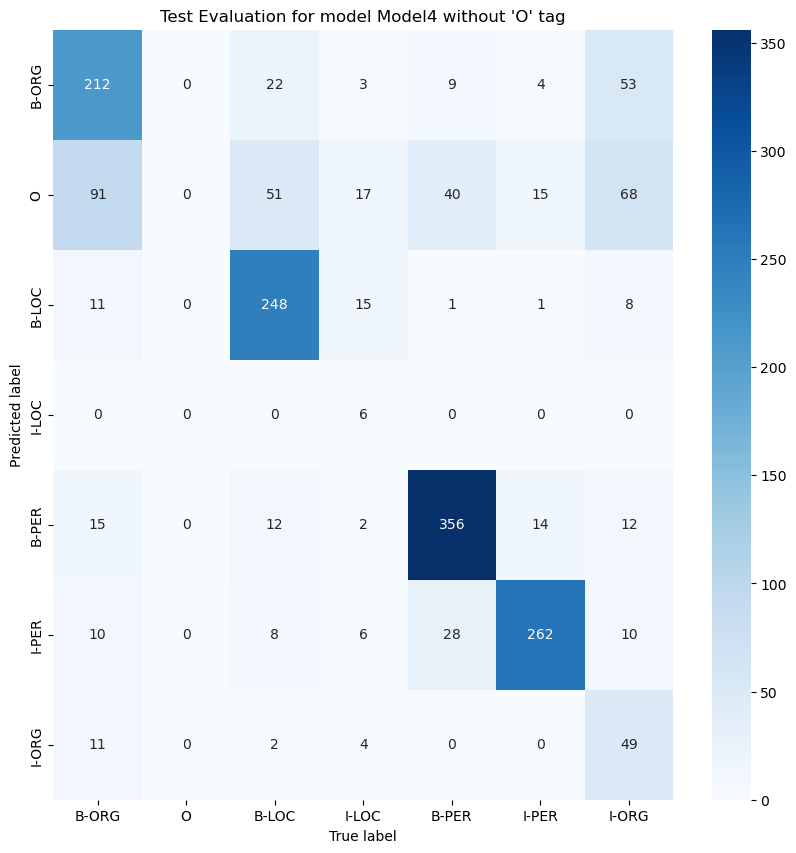

Dev Evaluation for model Model5 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.91127
Recall     0.899822
F1 Score   0.901844




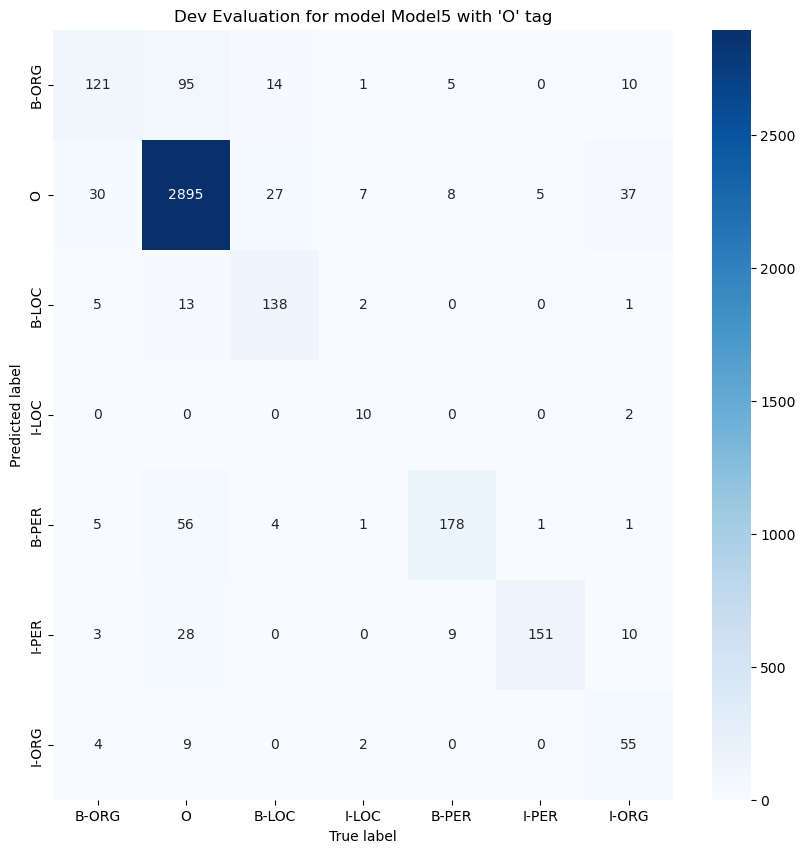

Dev Evaluation for model Model5 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.892273
Recall     0.770956
F1 Score   0.817526




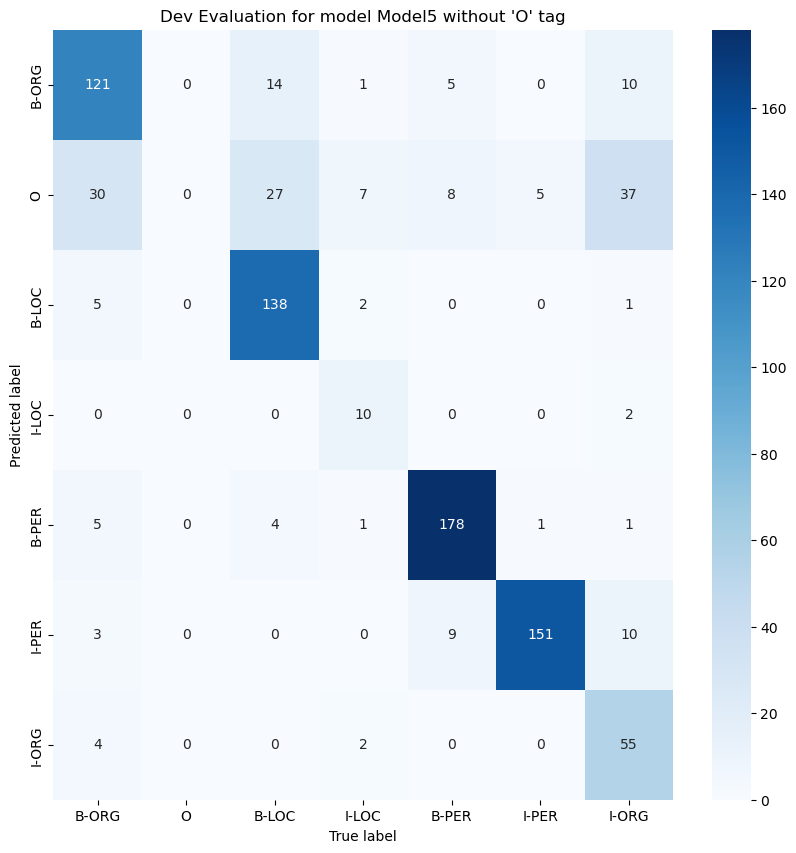

Test Evaluation for model Model5 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.905163
Recall     0.890089
F1 Score   0.894704




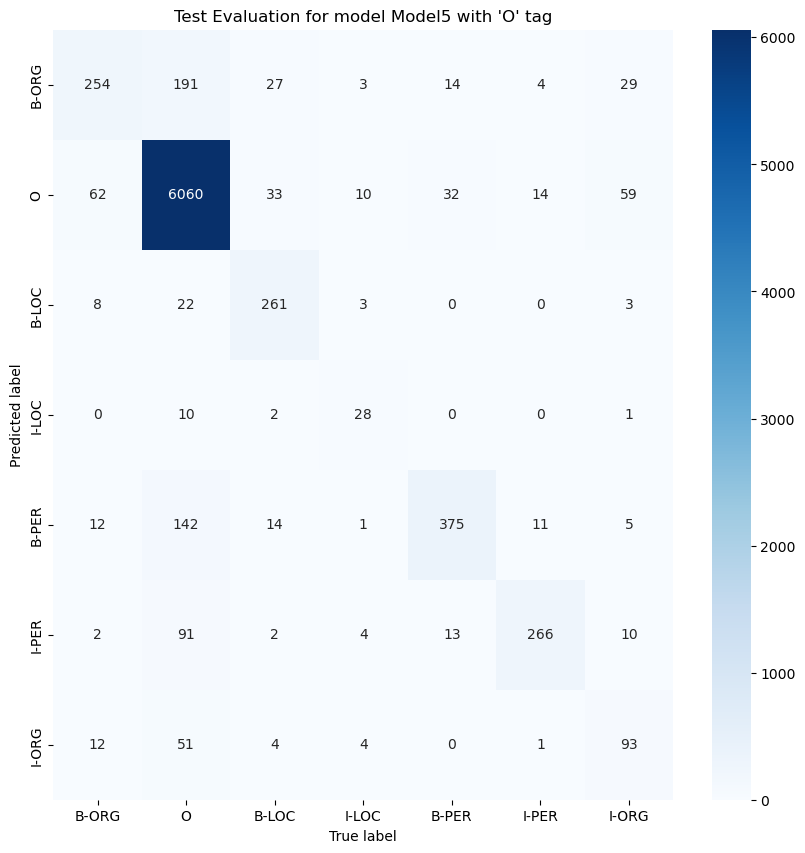

Test Evaluation for model Model5 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.870886
Recall     0.761933
F1 Score   0.806804




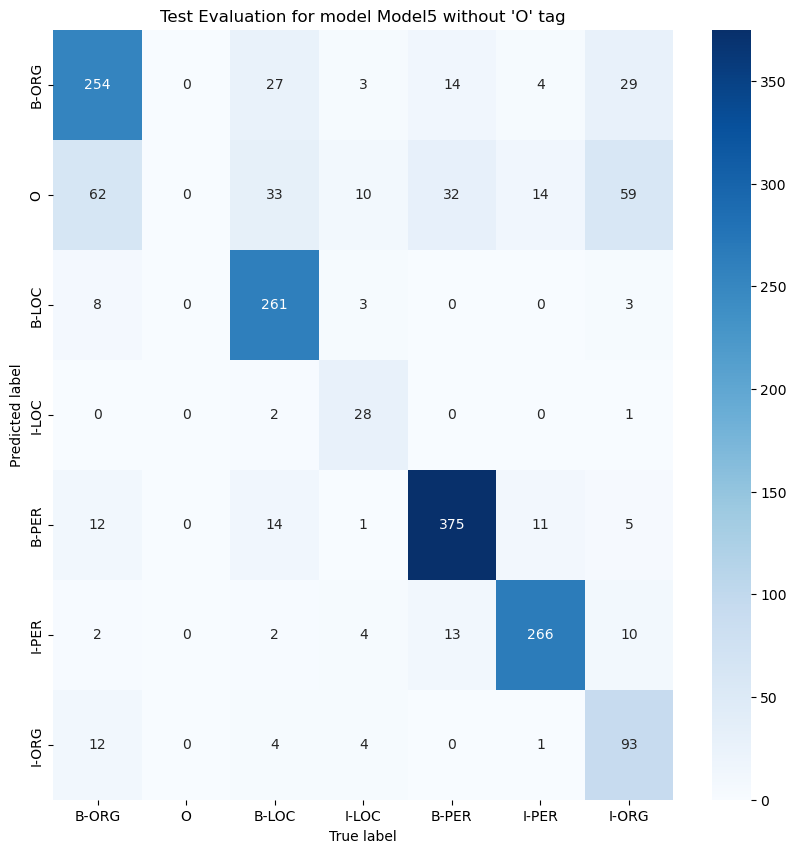

Dev Evaluation for model Model6 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.922039
Recall     0.914786
F1 Score   0.915637




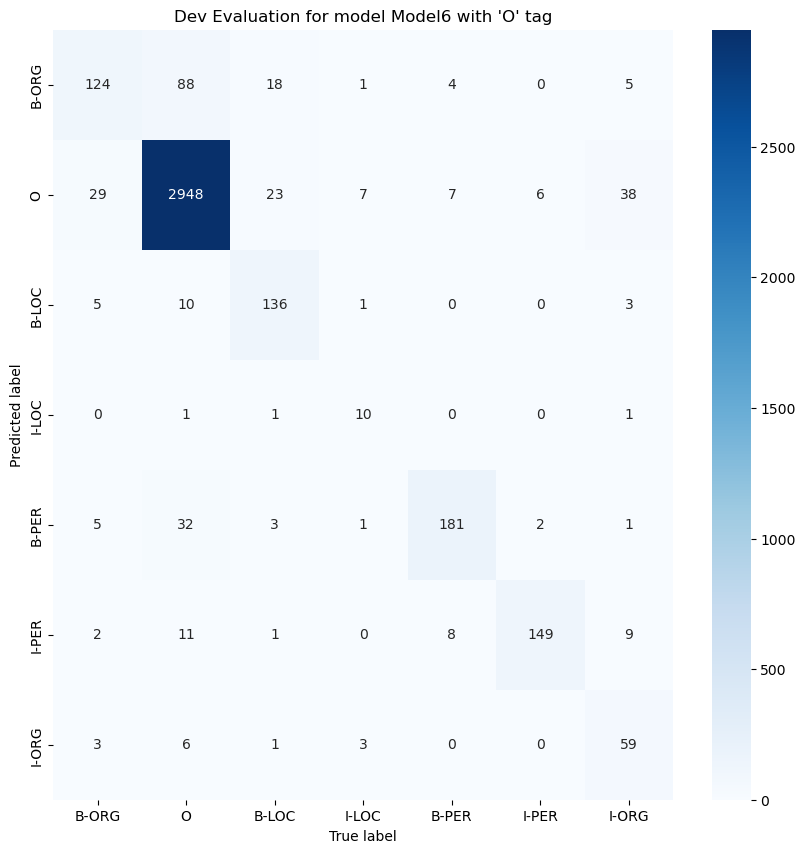

Dev Evaluation for model Model6 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.894383
Recall     0.77804
F1 Score   0.82414




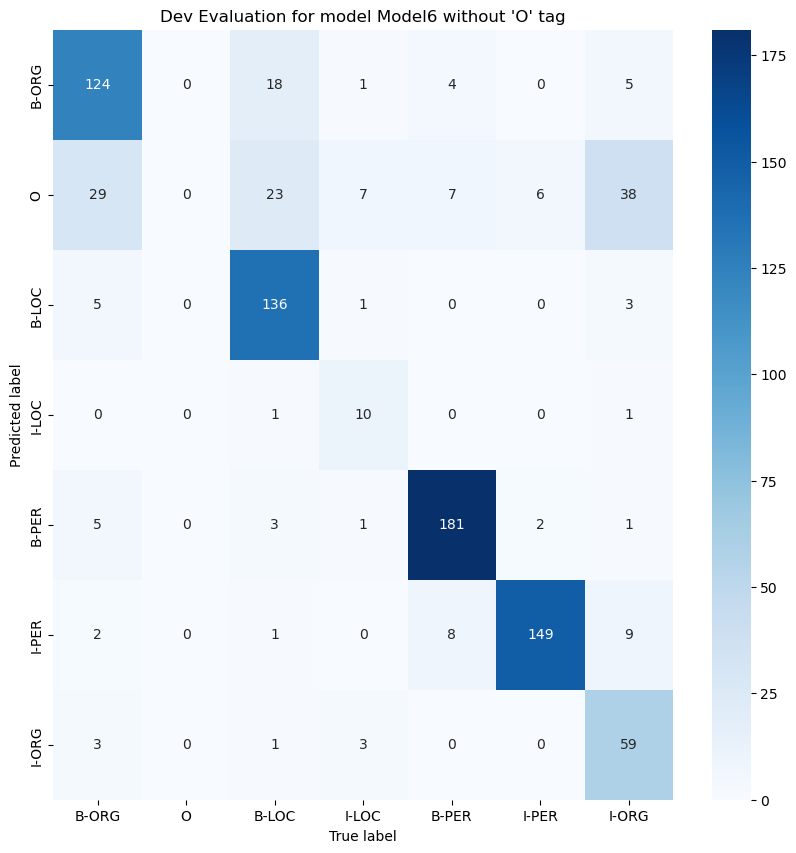

Test Evaluation for model Model6 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.916592
Recall     0.909499
F1 Score   0.911744




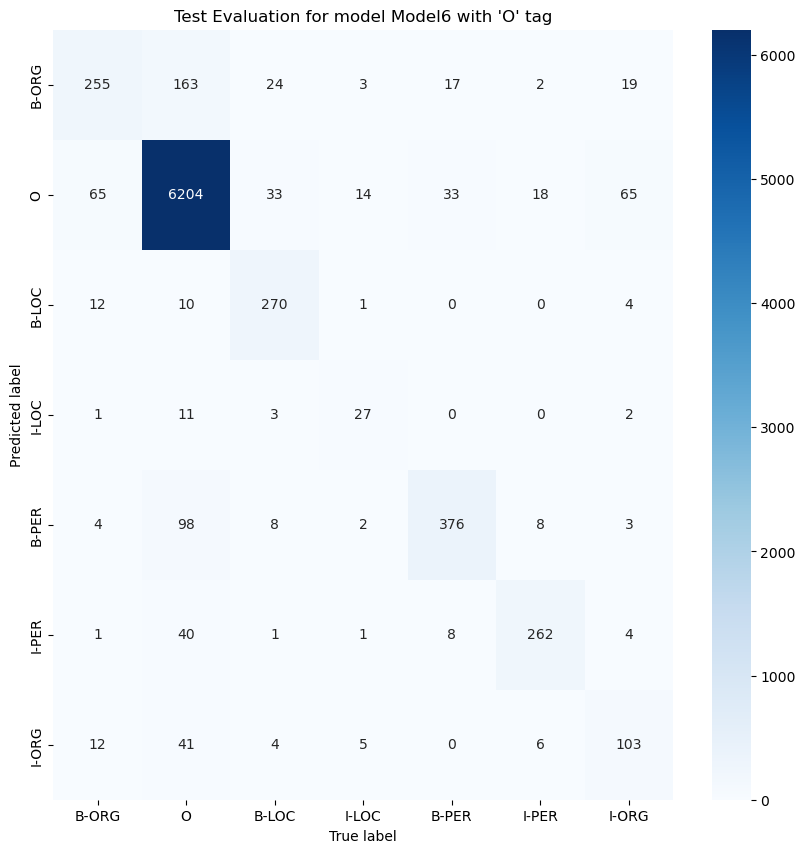

Test Evaluation for model Model6 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.889217
Recall     0.77148
F1 Score   0.823444




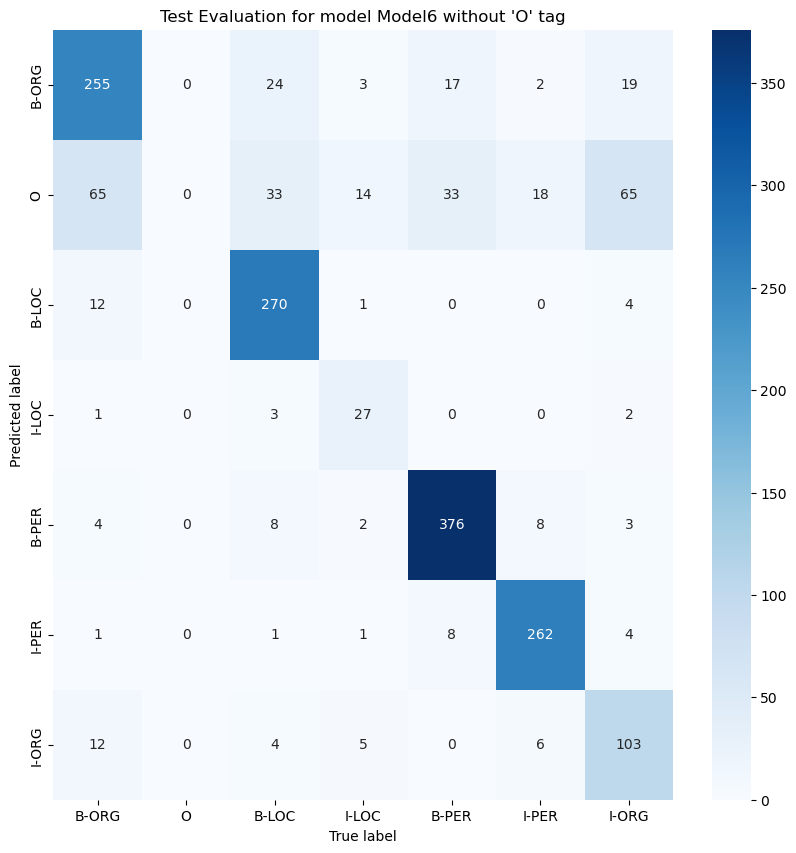

Dev Evaluation for model Model7 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.898949
Recall     0.883591
F1 Score   0.88421




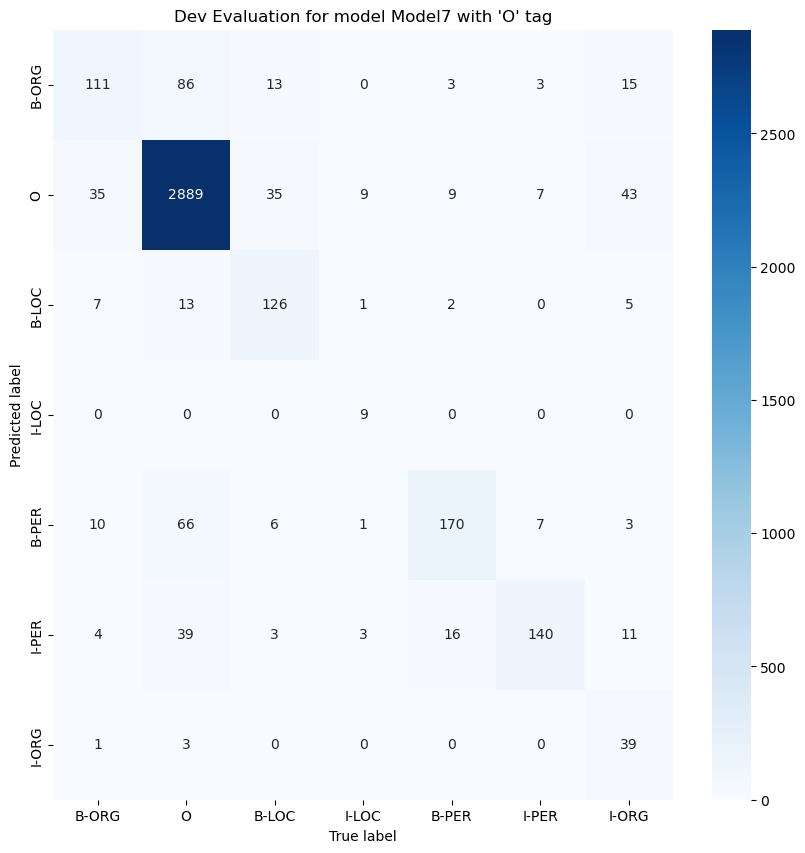

Dev Evaluation for model Model7 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.855972
Recall     0.702479
F1 Score   0.750093




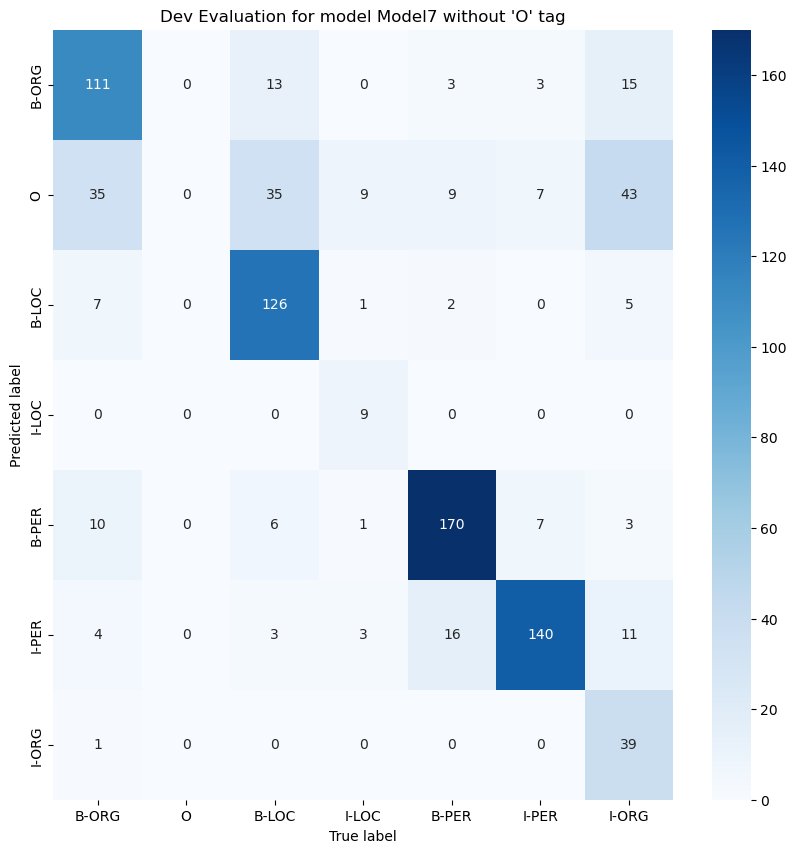

Test Evaluation for model Model7 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.887756
Recall     0.871649
F1 Score   0.875615




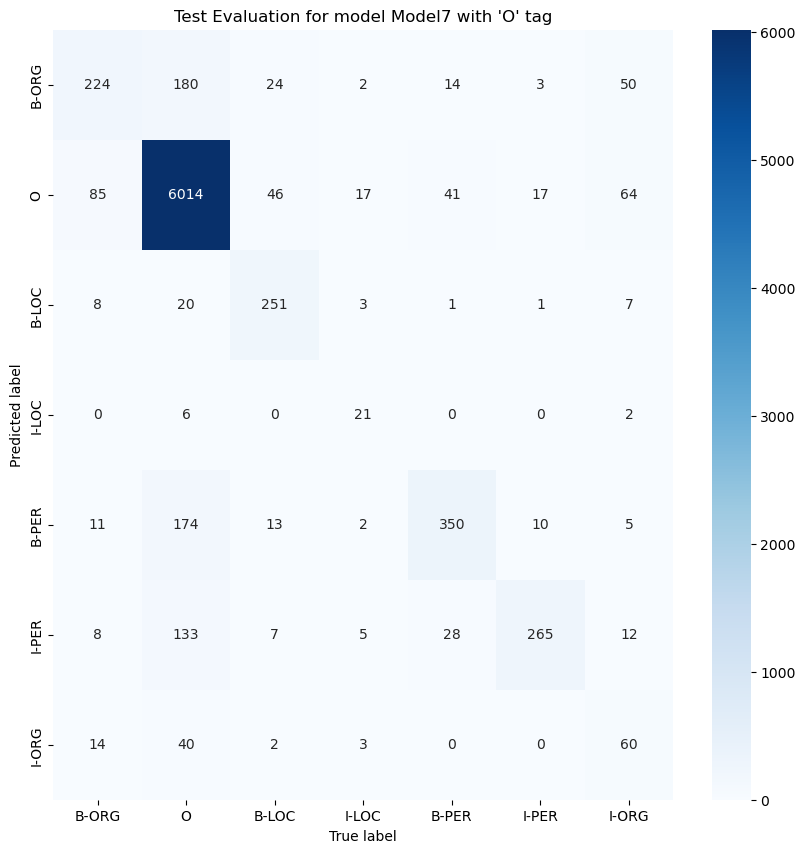

Test Evaluation for model Model7 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.832422
Recall     0.698687
F1 Score   0.746834




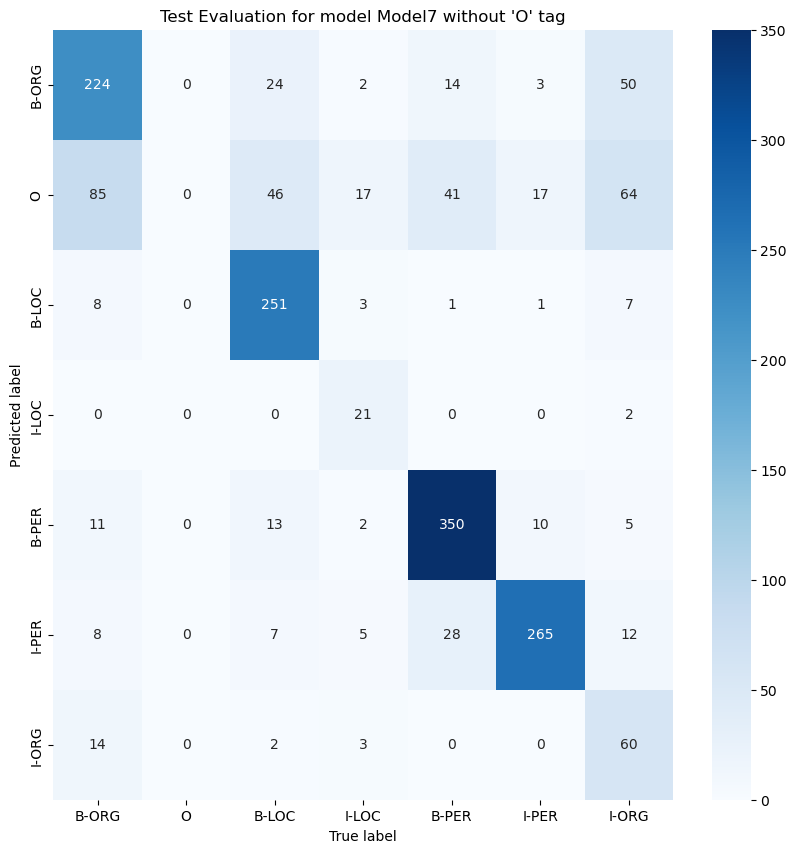

Dev Evaluation for model Model8 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.920998
Recall     0.918844
F1 Score   0.917821




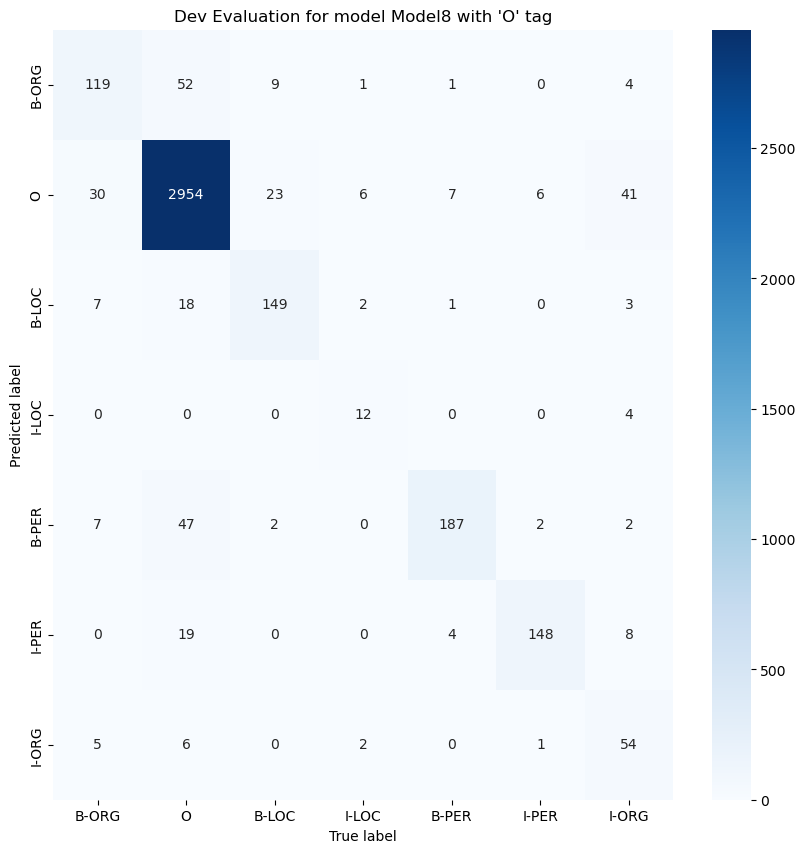

Dev Evaluation for model Model8 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.906749
Recall     0.789847
F1 Score   0.836602




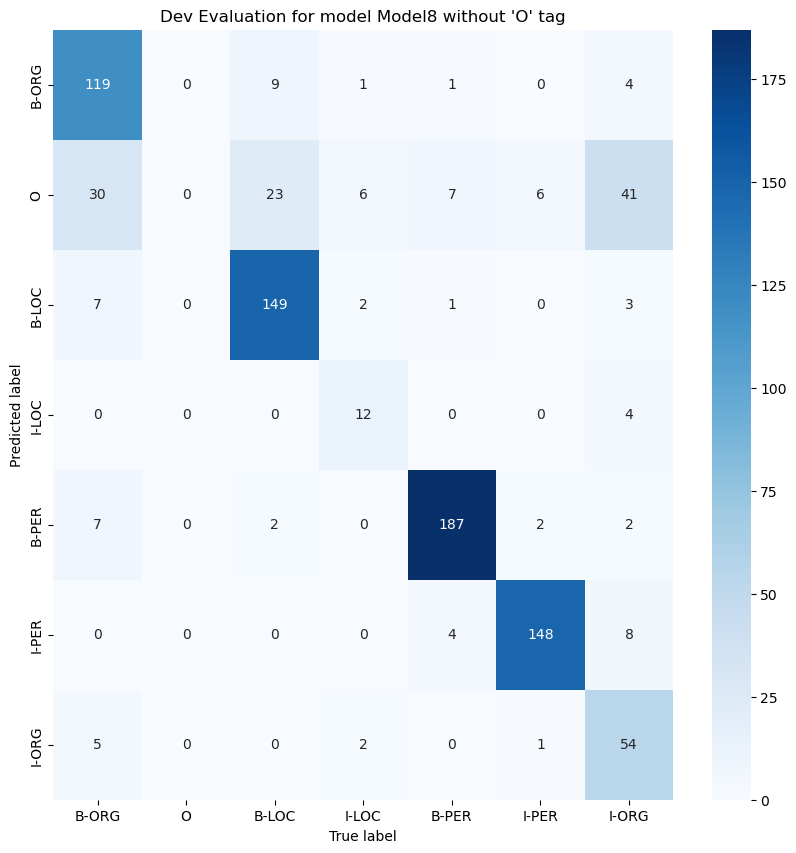

Test Evaluation for model Model8 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.913239
Recall     0.909378
F1 Score   0.909719




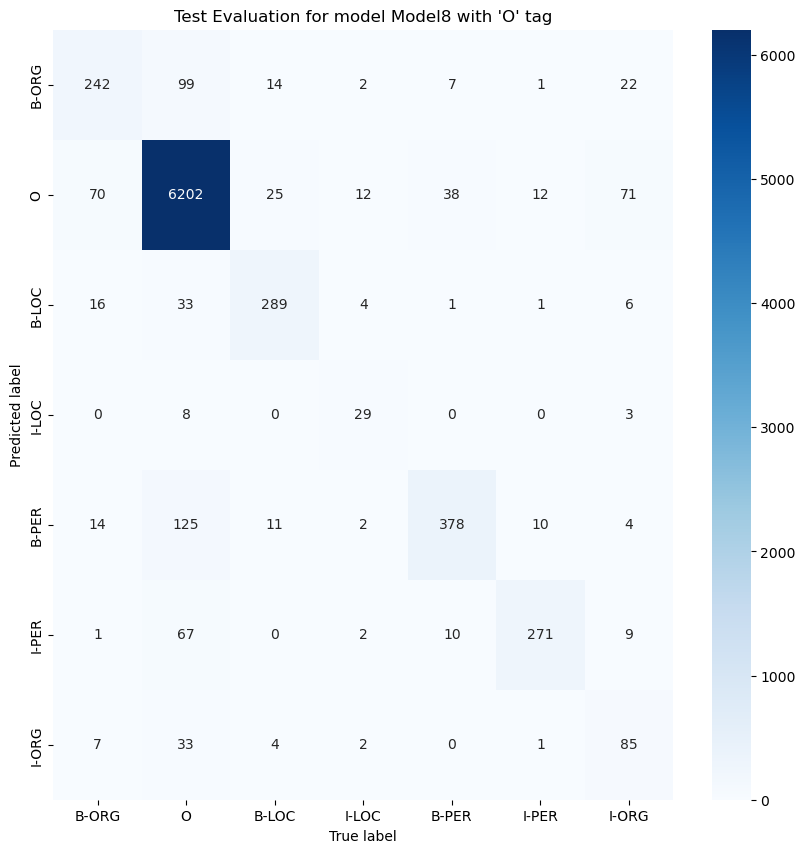

Test Evaluation for model Model8 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.890129
Recall     0.772076
F1 Score   0.819097




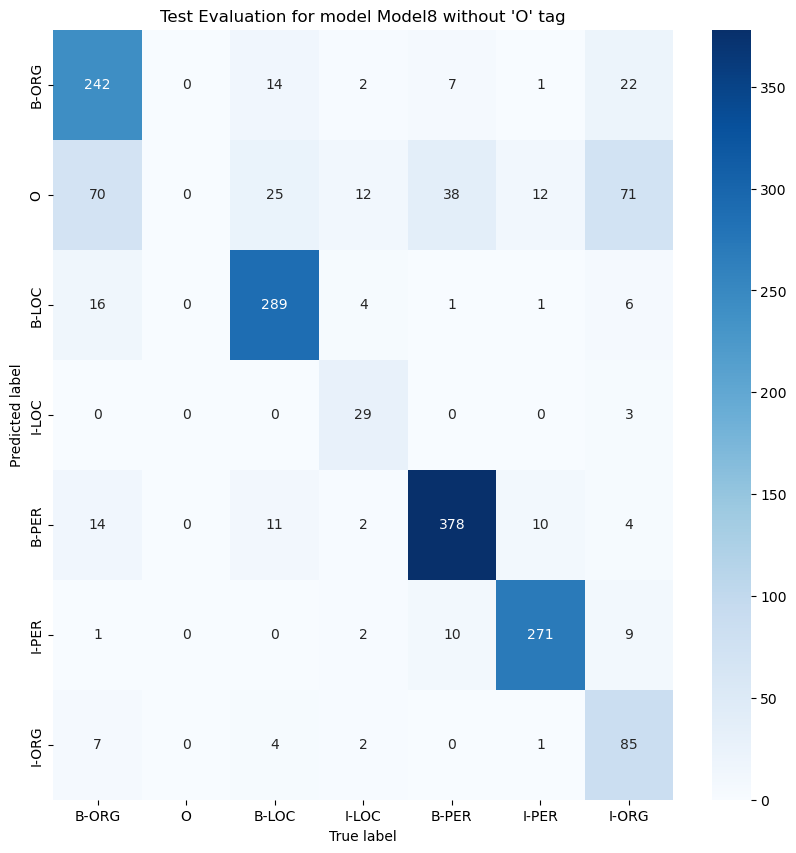

Dev Evaluation for model Model9 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.928461
Recall     0.923409
F1 Score   0.923151




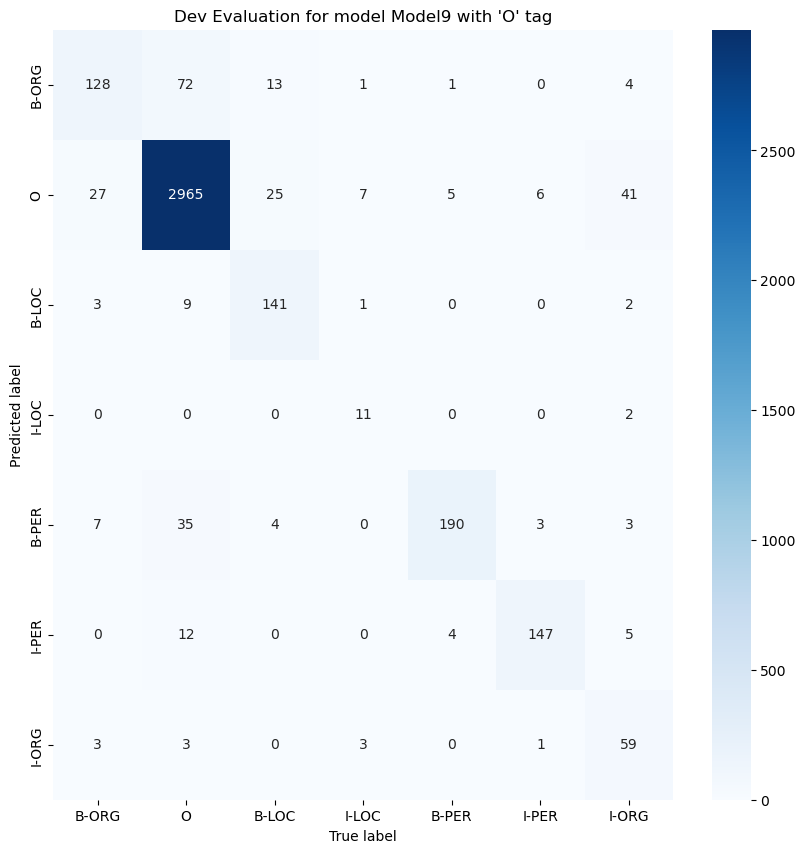

Dev Evaluation for model Model9 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.916756
Recall     0.798111
F1 Score   0.845787




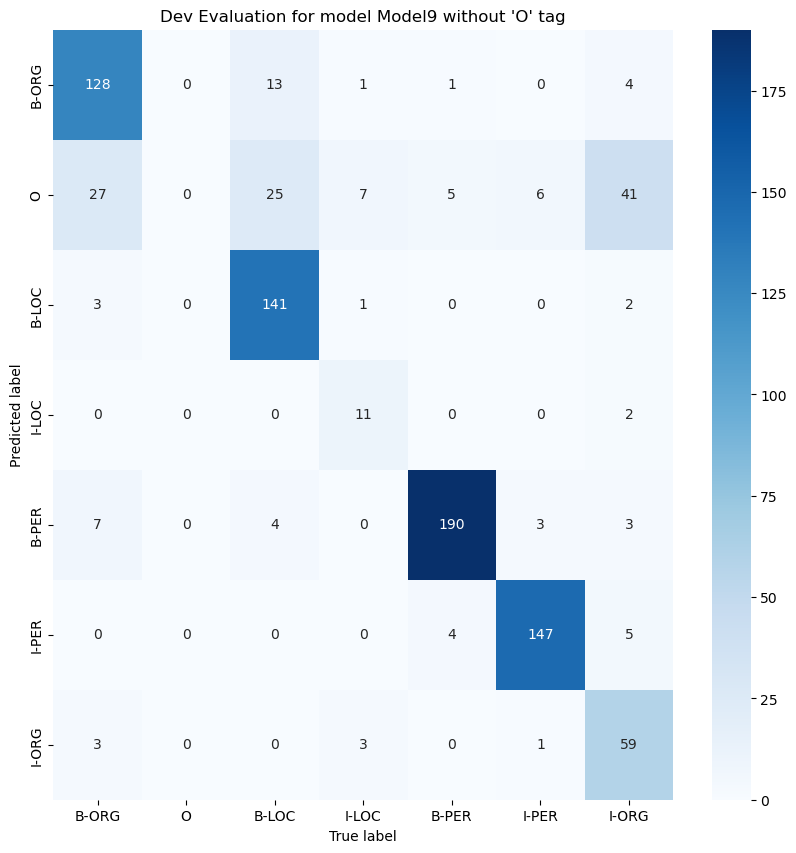

Test Evaluation for model Model9 with 'O' tag
Evaluation with O tags:
Metric        Score
---------  --------
Precision  0.921885
Recall     0.917021
F1 Score   0.918182




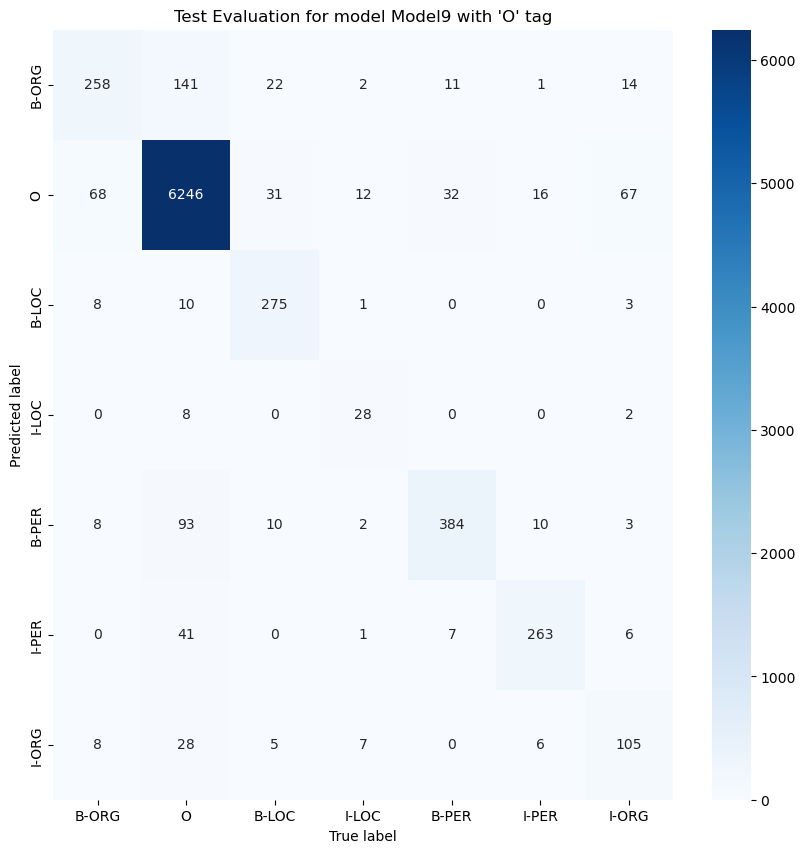

Test Evaluation for model Model9 without 'O' tag
Evaluation without O tags:
Metric        Score
---------  --------
Precision  0.902331
Recall     0.783413
F1 Score   0.835293




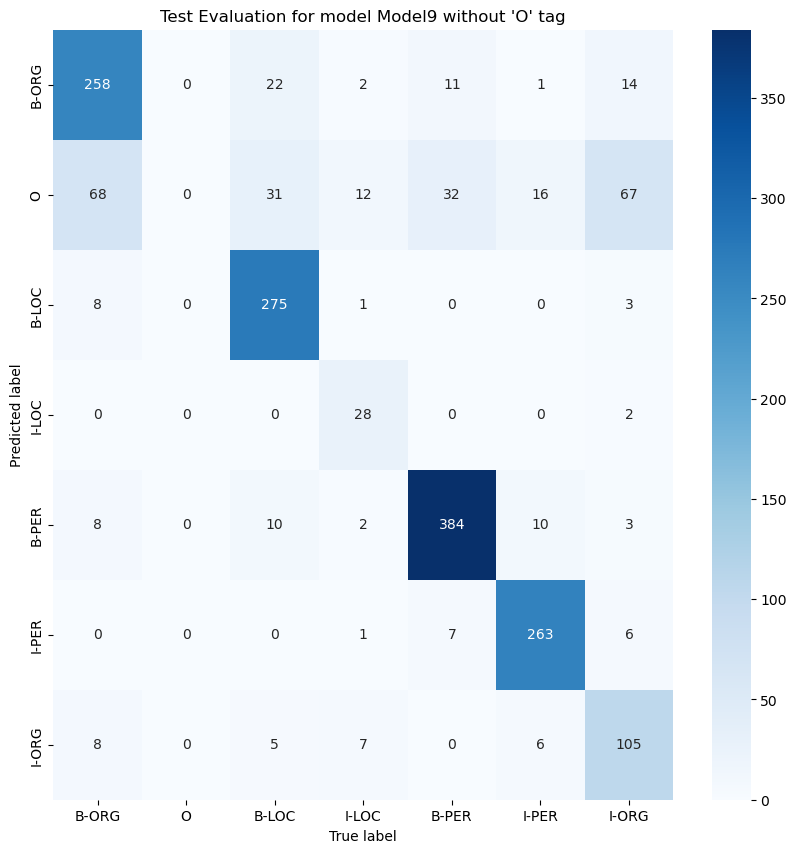

In [39]:
# print report and plot confusion matrix
for model_name in models_dict_glove.keys():
    # extract the results from the results (dev)
    hidden_size_dev = results_dev_glove[model_name]['HIDDEN_SIZE']
    n_layers_dev = results_dev_glove[model_name]['N_LAYERS']
    directions_dev = results_dev_glove[model_name]['DIRECTIONS']
    recall_dev_glove = results_dev_glove[model_name]['RECALL']
    precision_dev_glove = results_dev_glove[model_name]['PERCISION']
    f1_score_dev_glove = results_dev_glove[model_name]['F1']
    recall_without_O_dev_glove = results_dev_glove[model_name]['RECALL_WO_O']
    precision_without_O_dev_glove = results_dev_glove[model_name]['PERCISION_WO_O']
    f1_score_without_O_dev_glove = results_dev_glove[model_name]['F1_WO_O']
    cm_dev_glove = cm_dev_glove_dict[model_name]
    cm_dev_glove_without_O = cm_dev_glove_dict_without_O[model_name]
    # extract the results from the results (test)
    hidden_size_test = results_test_glove[model_name]['HIDDEN_SIZE']
    n_layers_test = results_test_glove[model_name]['N_LAYERS']
    directions_test = results_test_glove[model_name]['DIRECTIONS']
    recall_test_glove = results_test_glove[model_name]['RECALL']
    precision_test_glove = results_test_glove[model_name]['PERCISION']
    f1_score_test_glove = results_test_glove[model_name]['F1']
    recall_without_O_test_glove = results_test_glove[model_name]['RECALL_WO_O']
    precision_without_O_test_glove = results_test_glove[model_name]['PERCISION_WO_O']
    f1_score_without_O_test_glove = results_test_glove[model_name]['F1_WO_O']
    cm_test_glove = cm_test_glove_dict[model_name]
    cm_test_glove_without_O = cm_test_glove_dict_without_O[model_name]

    
    # print and plot dev evaluation with 'O' tag
    print_evaluation_percision_recall_f1(precision=precision_dev_glove, recall=recall_dev_glove, score=f1_score_dev_glove, cm=cm_dev_glove, without_O=False, title=f"Dev Evaluation for model {model_name} with 'O' tag", vocab=vocab)
    plot_confusion_matrix(cm=cm_dev_glove, labels=list(vocab.tag2id.keys()), title=f"Dev Evaluation for model {model_name} with 'O' tag")

    # print and plot dev evaluation without 'O' tag
    print_evaluation_percision_recall_f1(precision=precision_without_O_dev_glove, recall=recall_without_O_dev_glove, score=f1_score_without_O_dev_glove, cm=cm_dev_glove, without_O=True, title=f"Dev Evaluation for model {model_name} without 'O' tag", vocab=vocab)
    plot_confusion_matrix(cm=cm_dev_glove_without_O, labels=list(vocab.tag2id.keys()), title=f"Dev Evaluation for model {model_name} without 'O' tag")

    # print and plot test evaluation with 'O' tag
    print_evaluation_percision_recall_f1(precision=precision_test_glove, recall=recall_test_glove, score=f1_score_test_glove, cm=cm_test_glove, without_O=False, title=f"Test Evaluation for model {model_name} with 'O' tag", vocab=vocab)
    plot_confusion_matrix(cm=cm_test_glove, labels=list(vocab.tag2id.keys()), title=f"Test Evaluation for model {model_name} with 'O' tag")

    # print and plot test evaluation without 'O' tag
    print_evaluation_percision_recall_f1(precision=precision_without_O_test_glove, recall=recall_without_O_test_glove, score=f1_score_without_O_test_glove, cm=cm_test_glove, without_O=True, title=f"Test Evaluation for model {model_name} without 'O' tag", vocab=vocab)
    plot_confusion_matrix(cm=cm_test_glove_without_O, labels=list(vocab.tag2id.keys()), title=f"Test Evaluation for model {model_name} without 'O' tag")


- Save the results in a CSV {student_id_1}_{student_id_n}_part7.csv  
For example: 300123123_200456789_part_7.csv

- Print the results as follows:

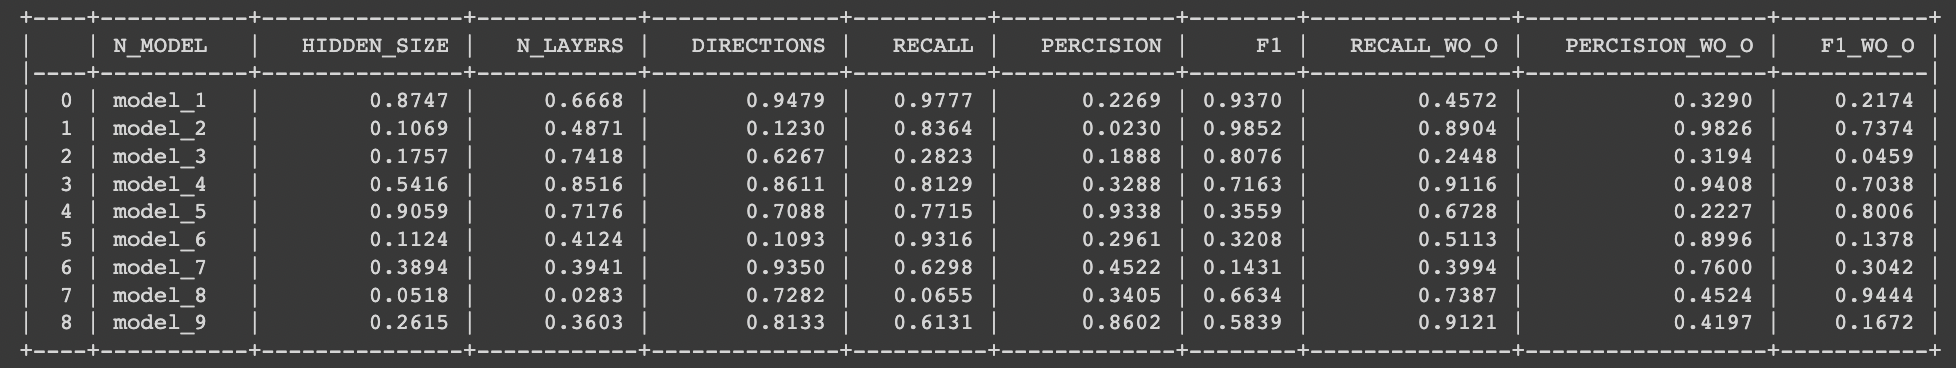

In [38]:
# TO DO
# print the results for the dev set in a table
print("Dev set")
print(tabulate(tabular_data=results_df_dev_glove.values, headers=results_df_dev_glove.columns.tolist(), tablefmt='github', showindex=False), '\n')

# print the results for the test set in a table
print("Test set")
print(tabulate(tabular_data=results_df_test_glove.values, headers=results_df_test_glove.columns.tolist(), tablefmt='github', showindex=False))


# Save the test results in a csv file
results_df_test_glove.to_csv('results_glove.csv', index=False)


Dev set
| N_MODEL   |   HIDDEN_SIZE |   N_LAYERS |   DIRECTIONS |   RECALL |   PERCISION |       F1 |   RECALL_WO_O |   PERCISION_WO_O |   F1_WO_O |
|-----------|---------------|------------|--------------|----------|-------------|----------|---------------|------------------|-----------|
| Model1    |           800 |          3 |            2 | 0.840223 |    0.869974 | 0.845663 |      0.636364 |         0.791923 |  0.669958 |
| Model2    |           800 |          3 |            2 | 0.871164 |    0.871794 | 0.865975 |      0.613932 |         0.795104 |  0.660672 |
| Model3    |           800 |          3 |            2 | 0.836926 |    0.824298 | 0.824362 |      0.526564 |         0.62646  |  0.524314 |
| Model4    |           800 |          3 |            2 | 0.87649  |    0.889563 | 0.874378 |      0.675325 |         0.838021 |  0.719375 |
| Model5    |           800 |          3 |            2 | 0.899822 |    0.91127  | 0.901844 |      0.770956 |         0.892273 |  0.817526 |
| Mod

<br><br><br><br><br><br>
**Good luck!**